In [1]:
# This notebook will be for Classification testing (Supervised Learning)
# Decision Tree, SGD Classifier/SVM - Logistic Regression
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

## Prepping Data for Model Training

In [2]:
# # importing dataset
# old way
from dotenv import load_dotenv

load_dotenv()

dataset_path = os.getenv('CLEANED_DATA_PATH')

df_cleaned = pd.read_csv(dataset_path)

In [3]:
# importing dataset
# df_cleaned = pd.read_parquet('data/application_cleaned.parquet', engine = 'pyarrow')

^ for some reason the OCCUPATION_TYPE column was behaving weirdly when I used this, maybe I did not run all the cells in the main notebook before exporting but idk

In [4]:
df_cleaned.shape

(307507, 45)

In [5]:
# removing ID column
df_cleaned.drop(labels='SK_ID_CURR', axis=1, inplace=True)

In [6]:
# goodbye new mothers
df_cleaned = df_cleaned[df_cleaned['NAME_INCOME_TYPE'] != 'Maternity leave']

In [7]:
# determing the imbalance ratio
imb_ratio = df_cleaned[df_cleaned['TARGET'] == 0]['TARGET'].count() / df_cleaned[df_cleaned['TARGET'] == 1]['TARGET'].count()
print(imb_ratio)

11.387785521492164


In [8]:
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
# categorical_cols

In [9]:
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('TARGET')
# numerical_cols

In [10]:
# viewing the number of null values in each column
null_counts = df_cleaned.isnull().sum()
print(null_counts)

TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
OCCUPATION_TYPE                41009
CNT_FAM_MEMBERS                    2
REGION_RATING_CLIENT_W_CITY        0
WEEKDAY_APPR_PROCESS_START         0
HOUR_APPR_PROCESS_START            0
REG_REGION_NOT_LIVE_REGION         0
R

In [11]:
# Separate features and target
X = df_cleaned.drop('TARGET', axis=1)
if 'SK_ID_CURR' in X.columns:
    X = X.drop('SK_ID_CURR', axis=1)  # Remove ID column if present
y = df_cleaned['TARGET']

## Splitting, Scaling, Imputing, and OHE

In [12]:
# # Feature scaling
# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# print('Applying feature scaling...')
# # Scale numerical features
# scaler = RobustScaler()
# X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
# print(f'Scaled {len(numerical_cols)} numerical columns')

In [13]:
# # Impute missing values for numerical columns with median

# missing_num_col = ['AMT_REQ_CREDIT_BUREAU_HOUR',
#  'AMT_REQ_CREDIT_BUREAU_DAY',
#  'AMT_REQ_CREDIT_BUREAU_WEEK',
#  'AMT_REQ_CREDIT_BUREAU_MON',
#  'AMT_REQ_CREDIT_BUREAU_QRT',
#  'AMT_REQ_CREDIT_BUREAU_YEAR',
#  'AMT_ANNUITY',
#  'OBS_60_CNT_SOCIAL_CIRCLE',
#  'DEF_60_CNT_SOCIAL_CIRCLE',
#  'CNT_FAM_MEMBERS',
#  'DAYS_LAST_PHONE_CHANGE']

# missing_cat_col = ['OCCUPATION_TYPE', 'NAME_TYPE_SUITE']

# num_imp = ColumnTransformer(transformers=
#                             [('numimp', SimpleImputer(strategy='median', add_indicator=True), missing_num_col),
#                             ('catimp', SimpleImputer(strategy='most_frequent', add_indicator=True), missing_cat_col)], 
#                          remainder="passthrough").set_output(transform='pandas')
# # num_imputer = SimpleImputer(strategy='mean', add_indicator=True)
# X_train = num_imp.fit_transform(X_train)

# # df_num_imputed = pd.DataFrame(num_imputed_array, columns=numerical_cols)


In [14]:
# null_counts = X_train.isnull().sum()
# print(null_counts)

In [15]:
# # Verify no missing values remain
# missing_after = X_train.isnull().sum().sum()
# print(f'Missing values after imputation: {missing_after}')

In [16]:
# categorical_cols_imp = X_train.select_dtypes(include=['object']).columns.tolist()

# categorical_cols_imp.remove('catimp__missingindicator_OCCUPATION_TYPE')
# categorical_cols_imp.remove('catimp__missingindicator_NAME_TYPE_SUITE')

# categorical_cols_imp

In [17]:
# # one hot encoding categorical variables for training set

# from sklearn.preprocessing import OneHotEncoder

# ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False), categorical_cols_imp)], 
#                        remainder="passthrough").set_output(transform='pandas')
# X_train = ct.fit_transform(X_train)

# # OneHotEncoder = OneHotEncoder()
# # OneHotEncoder.fit(X_train)
# # X_train = OneHotEncoder.transform(X_train)

# # ^This will include nulls. We will impute them. we can one hot encode all the categorical variables then use Bayesian ridge estimator. XGBoost is also viable, also requires one hot encoding, 
# # however can overfit.

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

In [ ]:
null_counts = X_train.isnull().sum()
print(null_counts)

In [ ]:
null_counts = X_test.isnull().sum()
print(null_counts)

In [63]:
# Applying preprocessing to X_train
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# Feature scaling
print(f'Applying feature scaling for X_train...')
# Scale numerical features
scaler = RobustScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
print(f'Scaled {len(numerical_cols)} numerical columns for X_train')
print('\n')


#Imputing missing values
print(f'Imputing missing values for X_train...')
num_imp = ColumnTransformer(transformers=
                           [('numimp', SimpleImputer(strategy='median', add_indicator=True), numerical_cols),
                           ('catimp', SimpleImputer(strategy='most_frequent', add_indicator=True), categorical_cols)], 
                        remainder="passthrough").set_output(transform='pandas')
# num_imputer = SimpleImputer(strategy='mean', add_indicator=True)
X_train = num_imp.fit_transform(X_train)
print(f'Imputed numerical columns & categorical columns for X_train')
print('\n')

# Verify no missing values remain
missing_after = X_train.isnull().sum().sum()
print(f'Missing values after imputation: {missing_after} for X_train')
print('\n')


categorical_cols_imp = X_train.select_dtypes(include=['object']).columns.tolist()
print(f'Number of Categorical Columns: {len(categorical_cols_imp)}')

# finding cat columns that are binary
binary_cat_col_imp = []
for col in categorical_cols_imp:
    if X_train[col].nunique() == 2:
        binary_cat_col_imp.append(col)
print(f'Number of Binary Categorical Columns: {len(binary_cat_col_imp)}')

# IT TOOK ME 30 MINUTES TO FIX THIS IT WOULD NOT LET ME APPEND AND REMOVE IN THE SAME LOOP I DONT KNOW WHY
for col in binary_cat_col_imp:
    categorical_cols_imp.remove(col)
print(f'Number of Multiclass Categorical Columns: {len(categorical_cols_imp)}')
        

# label encoding binary categorical variables
le = LabelEncoder()
for col in binary_cat_col_imp:
    X_train[col] = le.fit_transform(X_train[col])

# onehot encoding multiclass category variables
ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False), categorical_cols_imp)], 
                     remainder="passthrough").set_output(transform='pandas')

X_train = ct.fit_transform(X_train)

Applying feature scaling for X_train...
Scaled 31 numerical columns for X_train


Imputing missing values for X_train...
Imputed numerical columns & categorical columns for X_train


Missing values after imputation: 0 for X_train


Number of Categorical Columns: 14
Number of Binary Categorical Columns: 6
Number of Multiclass Categorical Columns: 8


In [64]:
# Applying preprocessing to X_test

# Feature scaling
print(f'Applying feature scaling for X_test...')
# Scale numerical features
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]) #transforming the test data as the same scaler used for train data
print(f'Scaled {len(numerical_cols)} numerical columns for X_test')
print('\n')

#Imputing missing values
print(f'Imputing missing values for X_test...')
X_test = num_imp.transform(X_test)
print(f'Imputed numerical columns & categorical columns for X_test')
print('\n')

# Verify no missing values remain
missing_after = X_test.isnull().sum().sum()
print(f'Missing values after imputation: {missing_after} for X_test')
print('\n')

categorical_cols_imp = X_test.select_dtypes(include=['object']).columns.tolist()
print(f'Number of Categorical Columns: {len(categorical_cols_imp)}')

# finding cat columns that are binary
binary_cat_col_imp = []
for col in categorical_cols_imp:
    if X_test[col].nunique() == 2:
        binary_cat_col_imp.append(col)
print(f'Number of Binary Categorical Columns: {len(binary_cat_col_imp)}')

# IT TOOK ME 30 MINUTES TO FIX THIS IT WOULD NOT LET ME APPEND AND REMOVE IN THE SAME LOOP I DONT KNOW WHY
for col in binary_cat_col_imp:
    categorical_cols_imp.remove(col)
print(f'Number of Multiclass Categorical Columns: {len(categorical_cols_imp)}')
        

# label encoding binary categorical variables
le = LabelEncoder()
for col in binary_cat_col_imp:
    X_test[col] = le.fit_transform(X_test[col])

# onehot encoding multiclass category variables and 
ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False), categorical_cols_imp)], 
                     remainder="passthrough").set_output(transform='pandas')
                     
X_test = ct.fit_transform(X_test)

Applying feature scaling for X_test...
Scaled 31 numerical columns for X_test


Imputing missing values for X_test...
Imputed numerical columns & categorical columns for X_test


Missing values after imputation: 0 for X_test


Number of Categorical Columns: 14
Number of Binary Categorical Columns: 6
Number of Multiclass Categorical Columns: 8


In [22]:
# null_counts = X_train.isnull().sum()
# print(null_counts)

In [41]:
null_counts = X_test.isnull().sum()
print(null_counts)

ohe__catimp__NAME_TYPE_SUITE_Children                0
ohe__catimp__NAME_TYPE_SUITE_Family                  0
ohe__catimp__NAME_TYPE_SUITE_Group of people         0
ohe__catimp__NAME_TYPE_SUITE_Other_A                 0
ohe__catimp__NAME_TYPE_SUITE_Other_B                 0
                                                    ..
remainder__remainder__LIVE_REGION_NOT_WORK_REGION    0
remainder__remainder__REG_CITY_NOT_LIVE_CITY         0
remainder__remainder__LIVE_CITY_NOT_WORK_CITY        0
remainder__remainder__DAYS_LAST_PHONE_CHANGE         1
remainder__remainder__FLAG_DOCUMENT_3                0
Length: 164, dtype: int64


In [65]:
# dropping missingindicator columns that are not present in both datasets
train_col_list = X_train.columns.to_list()

test_col_list = X_test.columns.to_list()

# finding columns that are only in train
diff_1 = [item for item in train_col_list if item not in test_col_list]

if len(diff_1) > 0:
    print(f'Removing...{diff_1} from X_train')
    X_train.drop(labels=diff_1, axis=1, inplace=True)

# finding columns that are only in test
diff_2 = [item for item in test_col_list if item not in train_col_list]

if len(diff_2) > 0:
    print(f'Removing...{diff_2} from X_test')
    X_test.drop(labels=diff_2, axis=1, inplace=True)

Removing...['ohe__catimp__NAME_FAMILY_STATUS_Unknown'] from X_train


In [25]:
# for col in ['remainder__catimp__missingindicator_OCCUPATION_TYPE', 'remainder__catimp__missingindicator_NAME_TYPE_SUITE']:
#     X_train[col] = X_train[col].astype(bool)
#     X_test[col] = X_test[col].astype(bool)

## Model Training Function

In [66]:
# function to evaluate models with different metrics

def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Create classification report
    report = classification_report(y_test, y_pred)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plot ROC curve
    # fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    # plt.figure(figsize=(12, 8))
    # plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'ROC Curve {model_name}')
    # plt.legend(loc="lower right")
    # plt.subplot(1, 2, 1);
    # plt.savefig(f'ml_results/{model_name}_roc_curve.png')


    # Plot Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    # plt.plot(recall_curve, precision_curve, label=f'PR curve (area = {pr_auc:.3f})')
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.title(f'Precision-Recall Curve {model_name}')
    # plt.legend(loc="lower left")
    # plt.subplot(1, 2, 2);
    # plt.savefig(f'ml_results/{model_name}_pr_curve.png')


    # Plot confusion matrix
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title(f'Confusion Matrix {model_name}');
    # plt.savefig(f'ml_results/{model_name}_confusion_matrix.png')

    # Return metrics
    return {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mcc': mcc,
        'classification_report': report
    }


## Ensemble Method

In [68]:
# Ensemble Method using Voting Classifier
from sklearn.ensemble import VotingClassifier

models = {
    'Logistic Regression': LogisticRegression(class_weight={0: 1.0, 1: 8}, max_iter=1000, random_state=69),
    'Random Forest': RandomForestClassifier(class_weight={0: 1.0, 1: 8}, random_state=69, n_estimators=100),
    # 'Decision Tree': DecisionTreeClassifier(class_weight={0: 1.0, 1: 8}, random_state=69),
    # 'Gradient Boosting': GradientBoostingClassifier(random_state=69),
    # 'XGBoost Classifier': XGBClassifier(scale_pos_weight=imb_ratio, n_estimators=500),
    # 'XGBoostRF Classifier': XGBRFClassifier(scale_pos_weight=imb_ratio, random_state=69)
}

ensemble_model = VotingClassifier(estimators=[
    ('lr', models['Logistic Regression']),
    ('rfc', models['Random Forest']),
    # ('dtc', models['Decision Tree']),
    # ('xgbc', models['XGBoost Classifier']),
    # ('xgbrf', models['XGBoostRF Classifier'],)
    ],
    voting='hard')


print(f"Evaluating ensemble with...")

ensemble_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = ensemble_model.predict(X_test)

# Make predictions
y_pred = ensemble_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Create classification report
report = classification_report(y_test, y_pred)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

result = {
        'model_name': 'Ensemble',
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mcc': mcc,
        'classification_report': report
    }
print(cm)
print(f"  Precision: {result['precision']:.4f}")
print(f"  Recall: {result['recall']:.4f}")
print(f"  F1 Score: {result['f1_score']:.4f}")
print(f"  MCC: {result['mcc']:.4f}")

Evaluating ensemble with...
[[56533     3]
 [ 4958     7]]
  Precision: 0.7000
  Recall: 0.0014
  F1 Score: 0.0028
  MCC: 0.0290


## Class Weights Method

XGBoost seems to be performing the best consistently, but logistic regression performed really well at a weight of 0.8

Evaluating Logistic Regression with weight:None...
[[56536     0]
 [ 4964     1]]
  Precision: 1.0000
  Recall: 0.0002
  F1 Score: 0.0004
  ROC AUC: 0.6696
  PR AUC: 0.1546
  MCC: 0.0136
Evaluating Decision Tree with weight:None...
[[51465  5071]
 [ 4348   617]]
  Precision: 0.1085
  Recall: 0.1243
  F1 Score: 0.1158
  ROC AUC: 0.5173
  PR AUC: 0.1517
  MCC: 0.0325
Evaluating Random Forest with weight:None...
[[56536     0]
 [ 4964     1]]
  Precision: 1.0000
  Recall: 0.0002
  F1 Score: 0.0004
  ROC AUC: 0.6491
  PR AUC: 0.1472
  MCC: 0.0136
Evaluating Gradient Boosting with weight:None...
[[56535     1]
 [ 4965     0]]
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.6820
  PR AUC: 0.1658
  MCC: -0.0012
Evaluating XGBoost Classifier with weight:None...
[[46136 10400]
 [ 3018  1947]]
  Precision: 0.1577
  Recall: 0.3921
  F1 Score: 0.2249
  ROC AUC: 0.6586
  PR AUC: 0.1537
  MCC: 0.1416
Evaluating XGBoostRF Classifier with weight:None...
[[37131 19405]
 [ 2142  282

/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

[[56536     0]
 [ 4965     0]]
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.6563
  PR AUC: 0.1563
  MCC: 0.0000
Evaluating Gradient Boosting with weight:1:11.34...
[[56535     1]
 [ 4965     0]]
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.6820
  PR AUC: 0.1658
  MCC: -0.0012
Evaluating XGBoost Classifier with weight:1:11.34...
[[46136 10400]
 [ 3018  1947]]
  Precision: 0.1577
  Recall: 0.3921
  F1 Score: 0.2249
  ROC AUC: 0.6586
  PR AUC: 0.1537
  MCC: 0.1416
Evaluating XGBoostRF Classifier with weight:1:11.34...
[[37131 19405]
 [ 2142  2823]]
  Precision: 0.1270
  Recall: 0.5686
  F1 Score: 0.2076
  ROC AUC: 0.6565
  PR AUC: 0.1461
  MCC: 0.1278


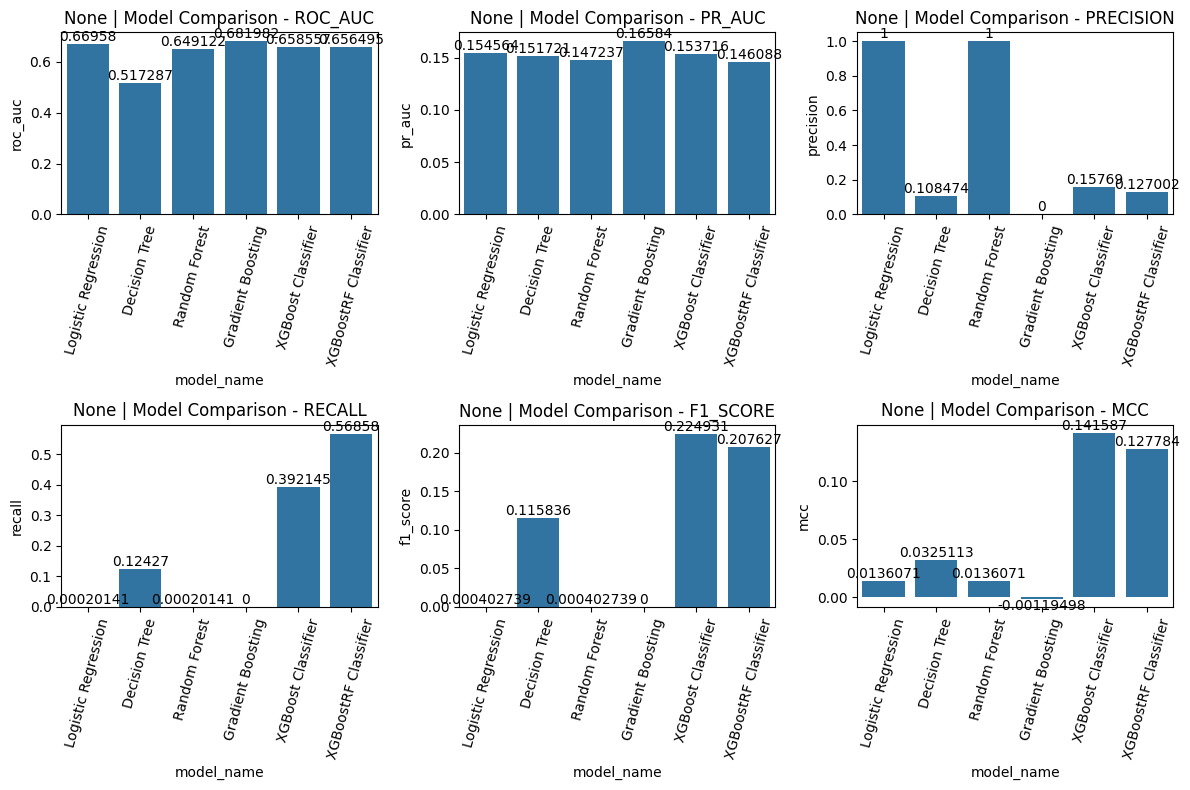

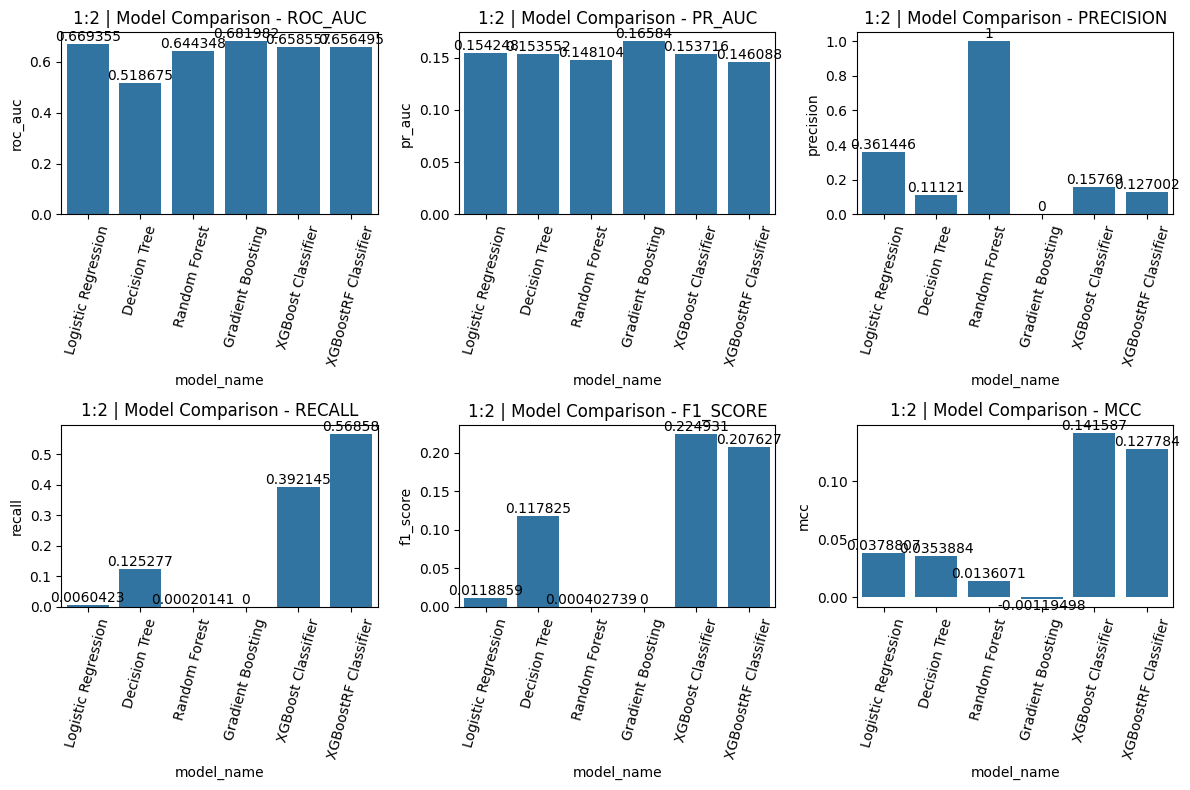

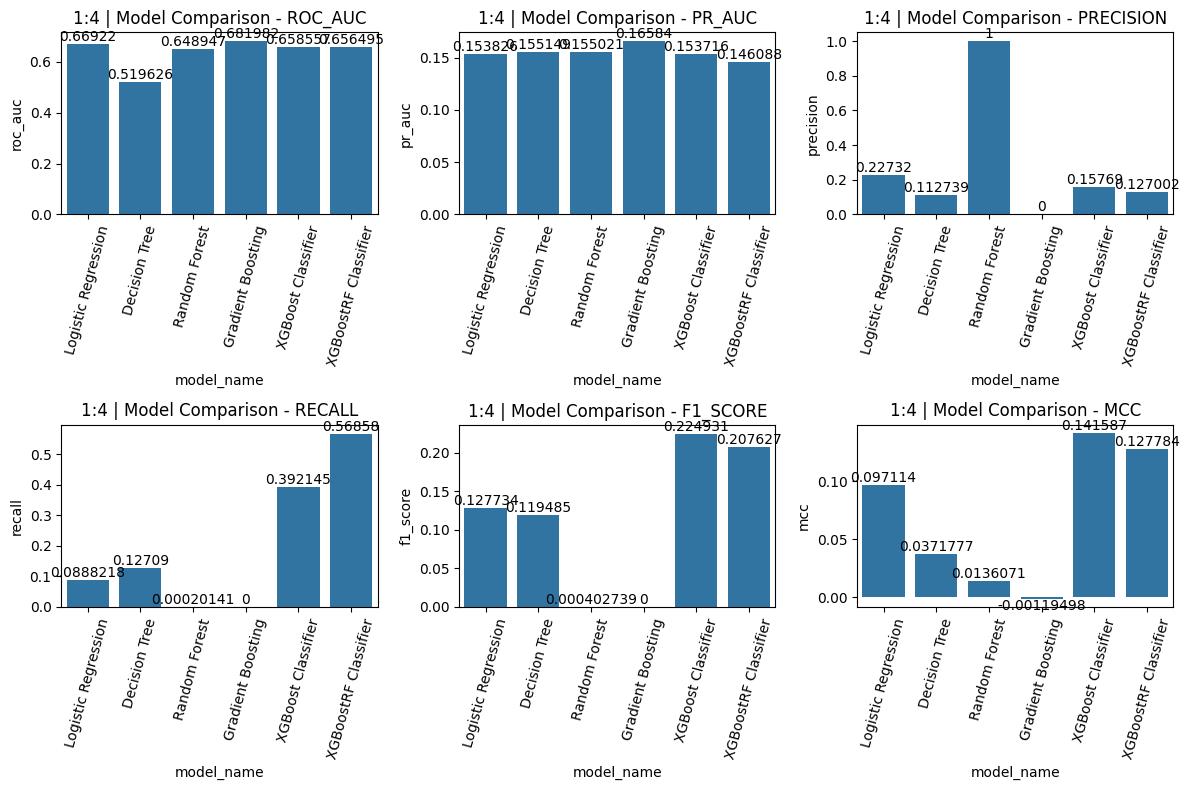

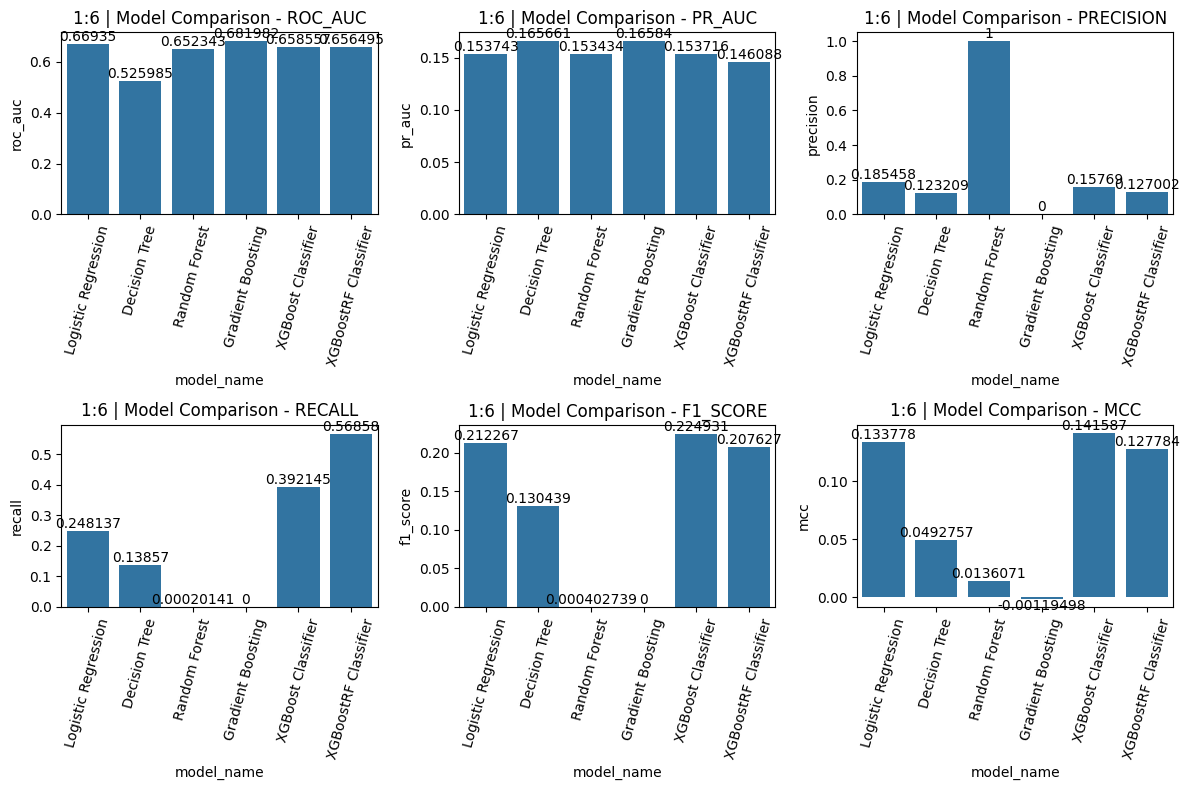

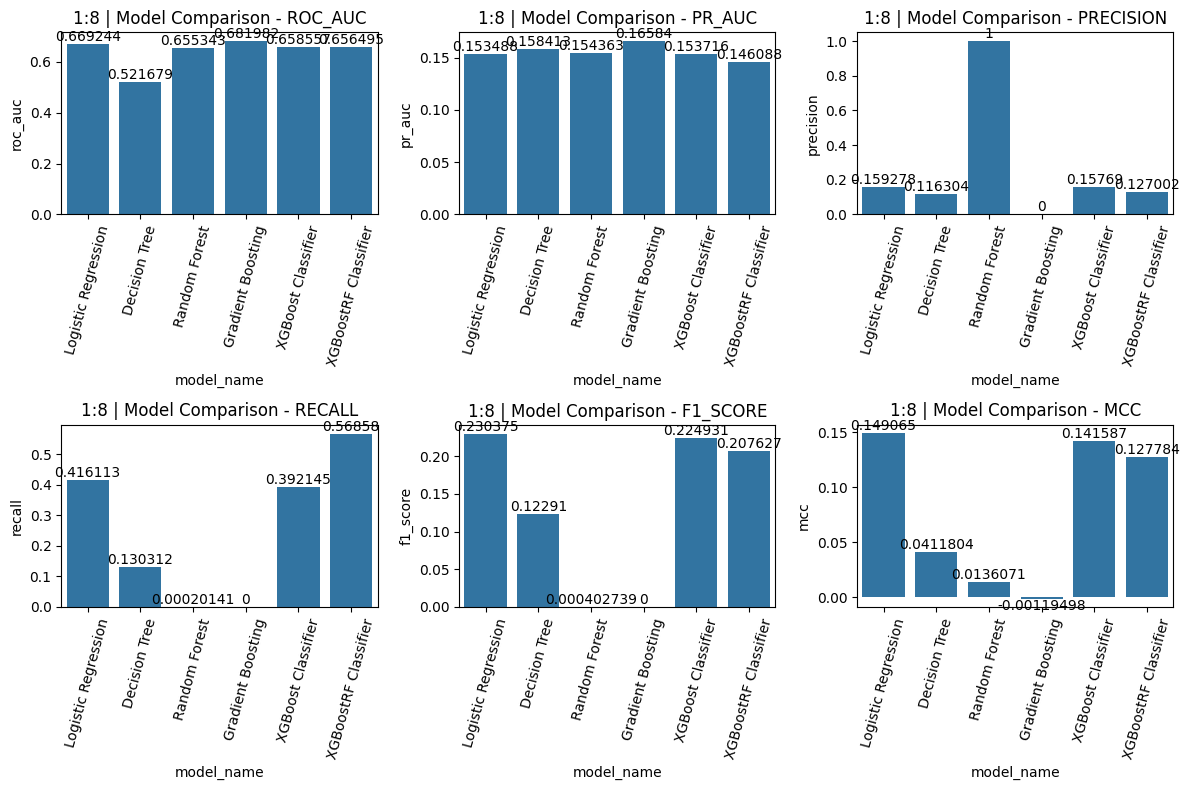

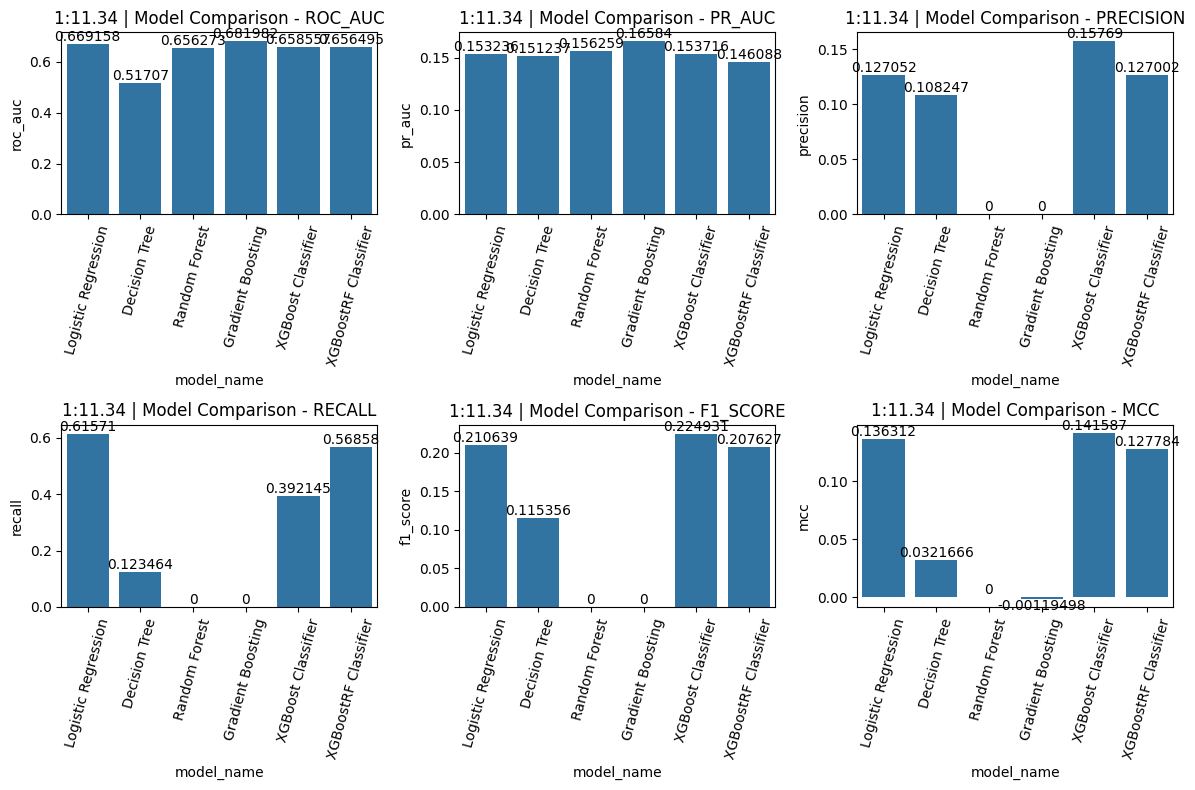

In [ ]:
# Evaluating Models with different class weights

# Create a dict of models

weights = {'None': {0: 1.0, 1: 1.0},
    '1:2': {0: 1.0, 1: 2},
    '1:4': {0: 1.0, 1: 4},
    '1:6': {0: 1.0, 1: 6},
    '1:8': {0: 1.0, 1: 8},
    '1:11.34': {0: 1.0, 1: 11.34}}


for weight_name, weight_dict in weights.items():
    models = {
        'Logistic Regression': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69),
        'Decision Tree': DecisionTreeClassifier(class_weight=weight_dict, random_state=69),
        'Random Forest': RandomForestClassifier(class_weight=weight_dict, random_state=69, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=69),
        'XGBoost Classifier': XGBClassifier(scale_pos_weight=weight_dict[1], n_estimators=500),
        'XGBoostRF Classifier': XGBRFClassifier(scale_pos_weight=weight_dict[1], random_state=69)
    }

    results = []
    for model_name, model in models.items():
        print(f"Evaluating {model_name} with weight:{weight_name}...")
        result = evaluate_model(model, model_name, X_train, X_test, y_train, y_test)
        results.append(result)
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall: {result['recall']:.4f}")
        print(f"  F1 Score: {result['f1_score']:.4f}")
        print(f"  ROC AUC: {result['roc_auc']:.4f}")
        print(f"  PR AUC: {result['pr_auc']:.4f}")
        print(f"  MCC: {result['mcc']:.4f}")
        # print(f"  Classification Report:\n{result['classification_report']}\n")

    # Create results summary
    results_df = pd.DataFrame(results)
    results_df = results_df.drop('classification_report', axis=1)
    # results_df.to_csv('ml_results/model_comparison.csv', index=False)

    # Plot model comparison
    plt.figure(figsize=(12, 8))
    metrics = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1_score', 'mcc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        ax = sns.barplot(x='model_name', y=metric, data=results_df)
        ax.bar_label(ax.containers[0],fontsize=10);
        plt.title(f'{weight_name} | Model Comparison - {metric.upper()}')
        plt.xticks(rotation=75)
        plt.tight_layout()

## Testing after adding phone columns and EXT_SOURCE 2 and 3

Evaluating Logistic Regression with weight:None...
[[56483    53]
 [ 4913    52]]
  Precision: 0.4952
  Recall: 0.0105
  F1 Score: 0.0205
  MCC: 0.0629
Evaluating Logistic Regression LL with weight:None...
[[56484    52]
 [ 4913    52]]
  Precision: 0.5000
  Recall: 0.0105
  F1 Score: 0.0205
  MCC: 0.0633
Evaluating Logistic Regression NC with weight:None...
[[56484    52]
 [ 4913    52]]
  Precision: 0.5000
  Recall: 0.0105
  F1 Score: 0.0205
  MCC: 0.0633
Evaluating XGBoost Classifier with weight:None...
[[47297  9239]
 [ 2820  2145]]
  Precision: 0.1884
  Recall: 0.4320
  F1 Score: 0.2624
  MCC: 0.1884
Evaluating SGD Classifier with weight:None...
[[56505    31]
 [ 4933    32]]
  Precision: 0.5079
  Recall: 0.0064
  F1 Score: 0.0127
  MCC: 0.0502
Evaluating Logistic Regression with weight:1:8...
[[45500 11036]
 [ 2400  2565]]
  Precision: 0.1886
  Recall: 0.5166
  F1 Score: 0.2763
  MCC: 0.2110
Evaluating Logistic Regression LL with weight:1:8...
[[45504 11032]
 [ 2398  2567]]
  Pre

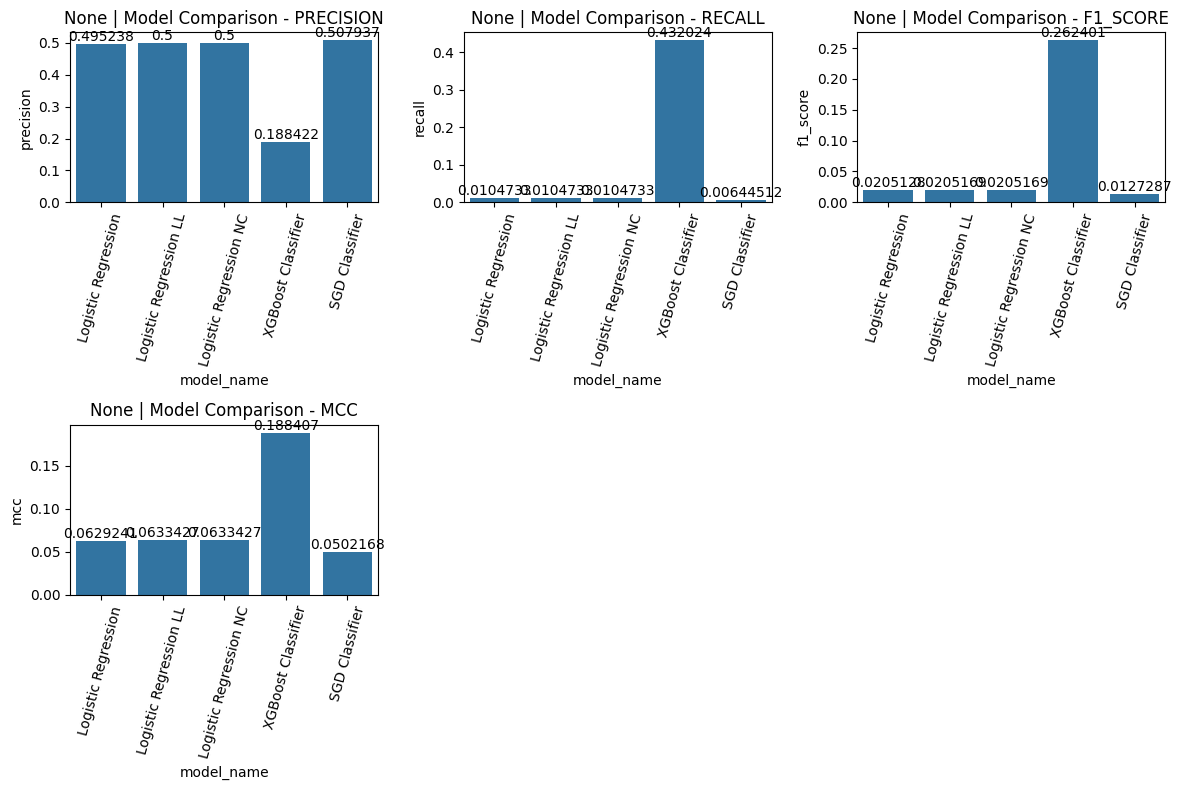

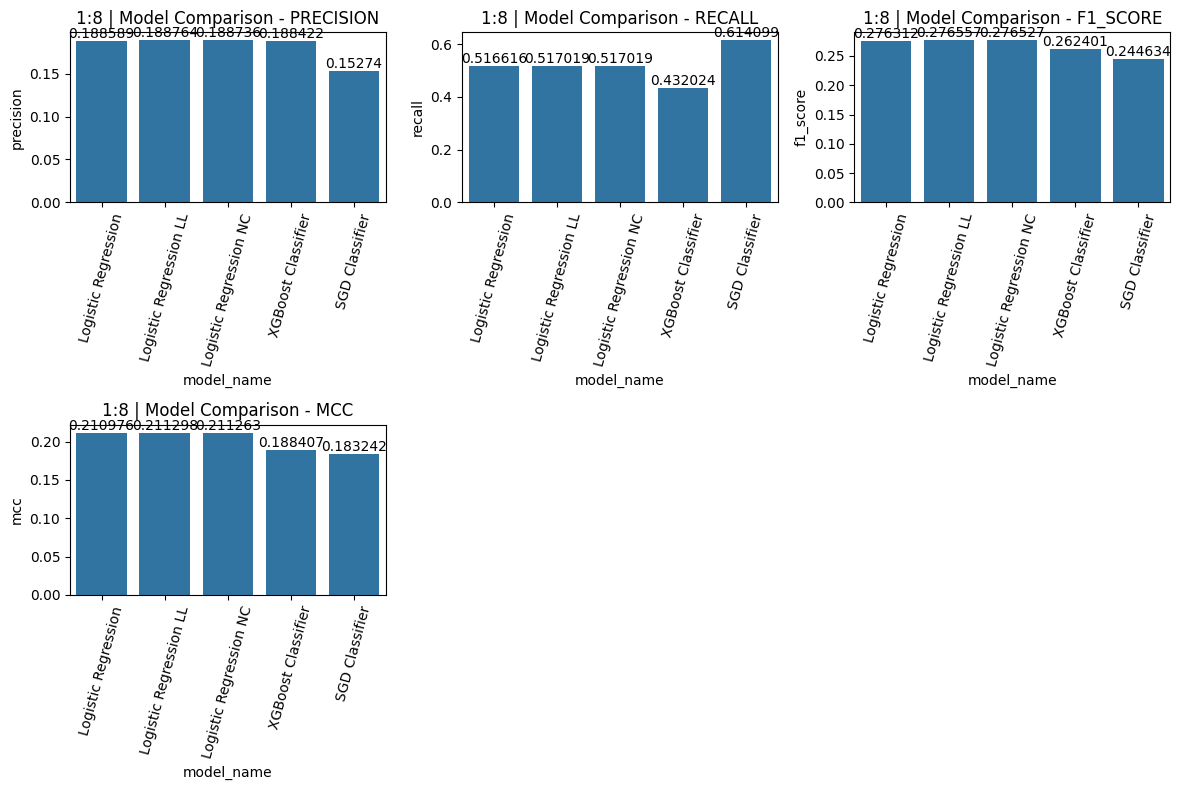

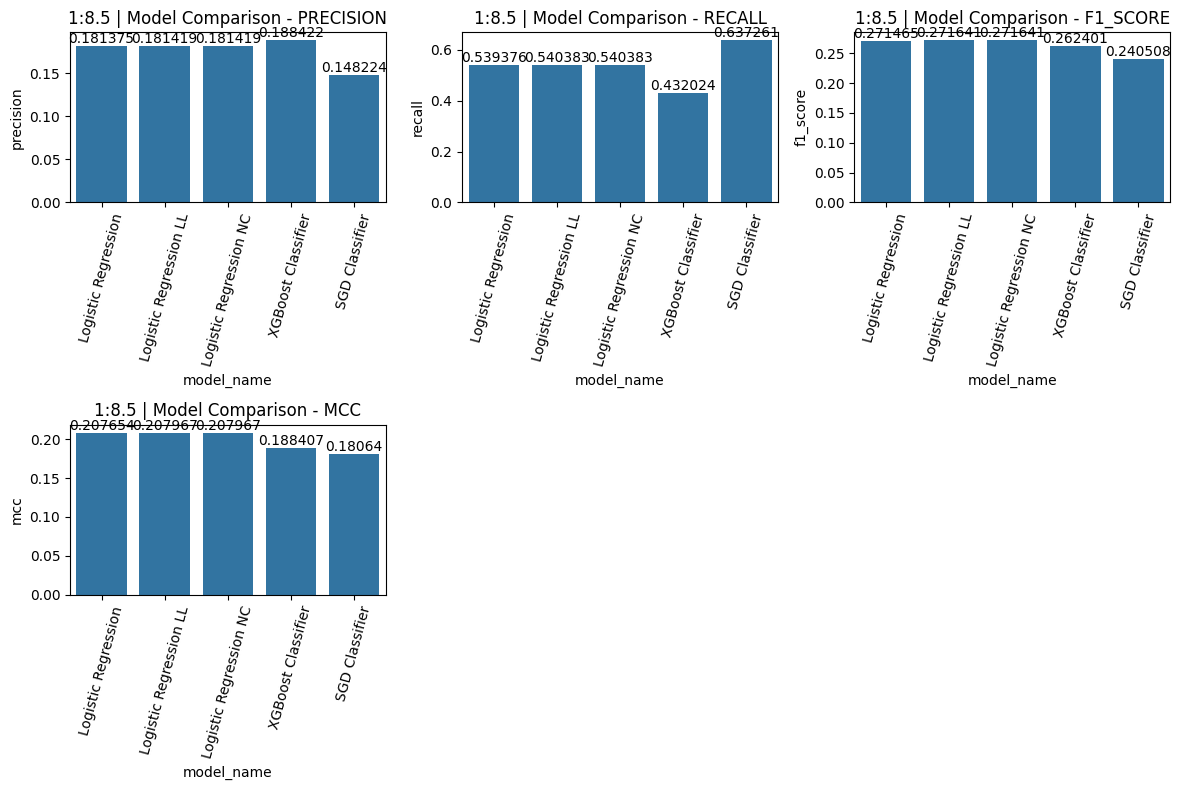

In [ ]:
weights = {'None': {0: 1.0, 1: 1.0},
    '1:8': {0: 1.0, 1: 8},
    '1:8.5': {0: 1.0, 1: 8.5}}


for weight_name, weight_dict in weights.items():
    models = {
        'Logistic Regression': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69),
        'Logistic Regression LL': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69, solver='liblinear'),
        'Logistic Regression NC': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69, solver='newton-cholesky'),
        'XGBoost Classifier': XGBClassifier(scale_pos_weight=weight_dict[1], n_estimators=500),
        'SGD Classifier': SGDClassifier(loss='log_loss', random_state=69, class_weight=weight_dict)}

    results = []
    for model_name, model in models.items():
        print(f"Evaluating {model_name} with weight:{weight_name}...")

        model.fit(X_train, y_train)

        # Predict the labels for the test set
        y_pred = model.predict(X_test)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)

        # Create classification report
        report = classification_report(y_test, y_pred)

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        result = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mcc': mcc,
        'classification_report': report}

        results.append(result)
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall: {result['recall']:.4f}")
        print(f"  F1 Score: {result['f1_score']:.4f}")
        print(f"  MCC: {result['mcc']:.4f}")
        # print(f"  Classification Report:\n{result['classification_report']}\n")

    # Create results summary
    results_df = pd.DataFrame(results)
    results_df = results_df.drop('classification_report', axis=1)
    # results_df.to_csv('ml_results/model_comparison.csv', index=False)

    # Plot model comparison
    plt.figure(figsize=(12, 8))
    metrics = ['precision', 'recall', 'f1_score', 'mcc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        ax = sns.barplot(x='model_name', y=metric, data=results_df)
        ax.bar_label(ax.containers[0],fontsize=10);
        plt.title(f'{weight_name} | Model Comparison - {metric.upper()}')
        plt.xticks(rotation=75)
        plt.tight_layout()

## Variants of Logistic Regression

Evaluating Logistic Regression LBF with weight:None...
[[56483    53]
 [ 4913    52]]
  Accuracy: 0.9193
  Precision: 0.4952
  Recall: 0.0105
  F1 Score: 0.0205
  ROC AUC: 0.7327
  PR AUC: 0.2122
  MCC: 0.0629
Evaluating Logistic Regression LL with weight:None...
[[56483    53]
 [ 4913    52]]
  Accuracy: 0.9193
  Precision: 0.4952
  Recall: 0.0105
  F1 Score: 0.0205
  ROC AUC: 0.7327
  PR AUC: 0.2122
  MCC: 0.0629
Evaluating Logistic Regression LBF with weight:1:7.7...
[[46074 10462]
 [ 2490  2475]]
  Accuracy: 0.7894
  Precision: 0.1913
  Recall: 0.4985
  F1 Score: 0.2765
  ROC AUC: 0.7326
  PR AUC: 0.2112
  MCC: 0.2095
Evaluating Logistic Regression LL with weight:1:7.7...
[[46074 10462]
 [ 2490  2475]]
  Accuracy: 0.7894
  Precision: 0.1913
  Recall: 0.4985
  F1 Score: 0.2765
  ROC AUC: 0.7326
  PR AUC: 0.2112
  MCC: 0.2095
Evaluating Logistic Regression LBF with weight:1:7.8...
[[45880 10656]
 [ 2449  2516]]
  Accuracy: 0.7869
  Precision: 0.1910
  Recall: 0.5067
  F1 Score: 0.277

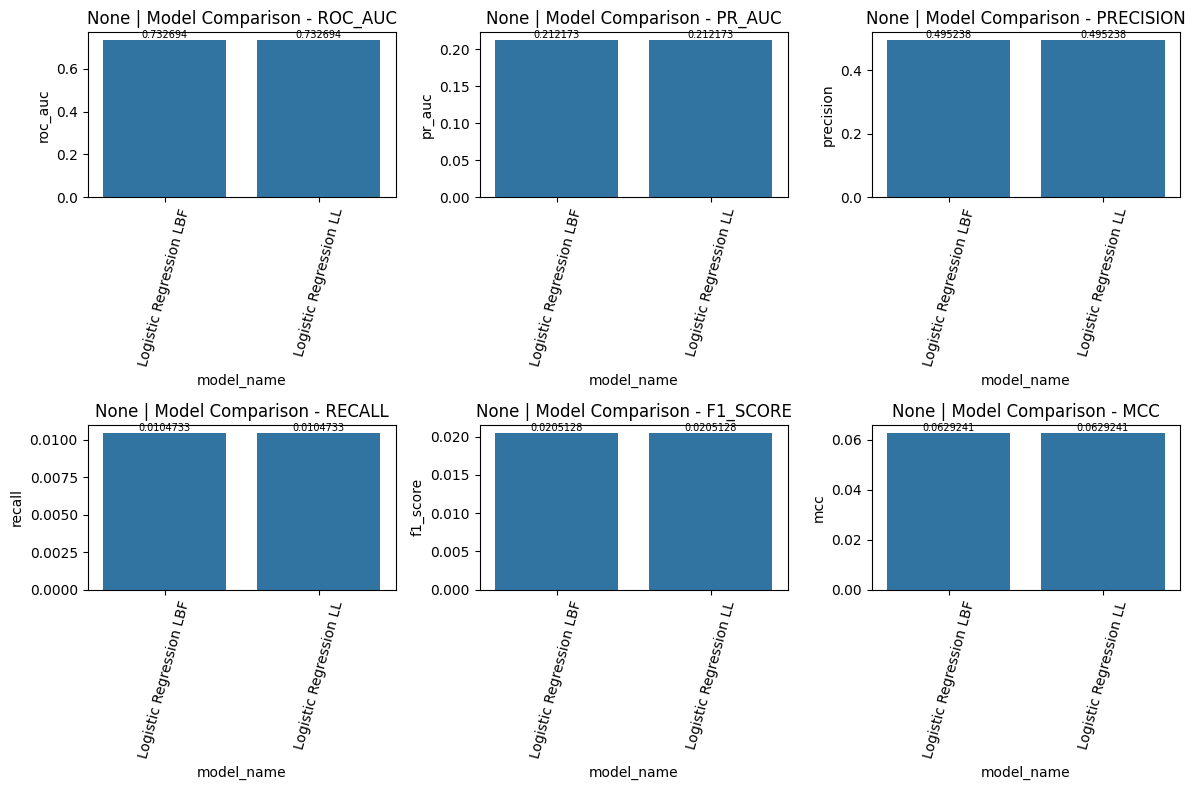

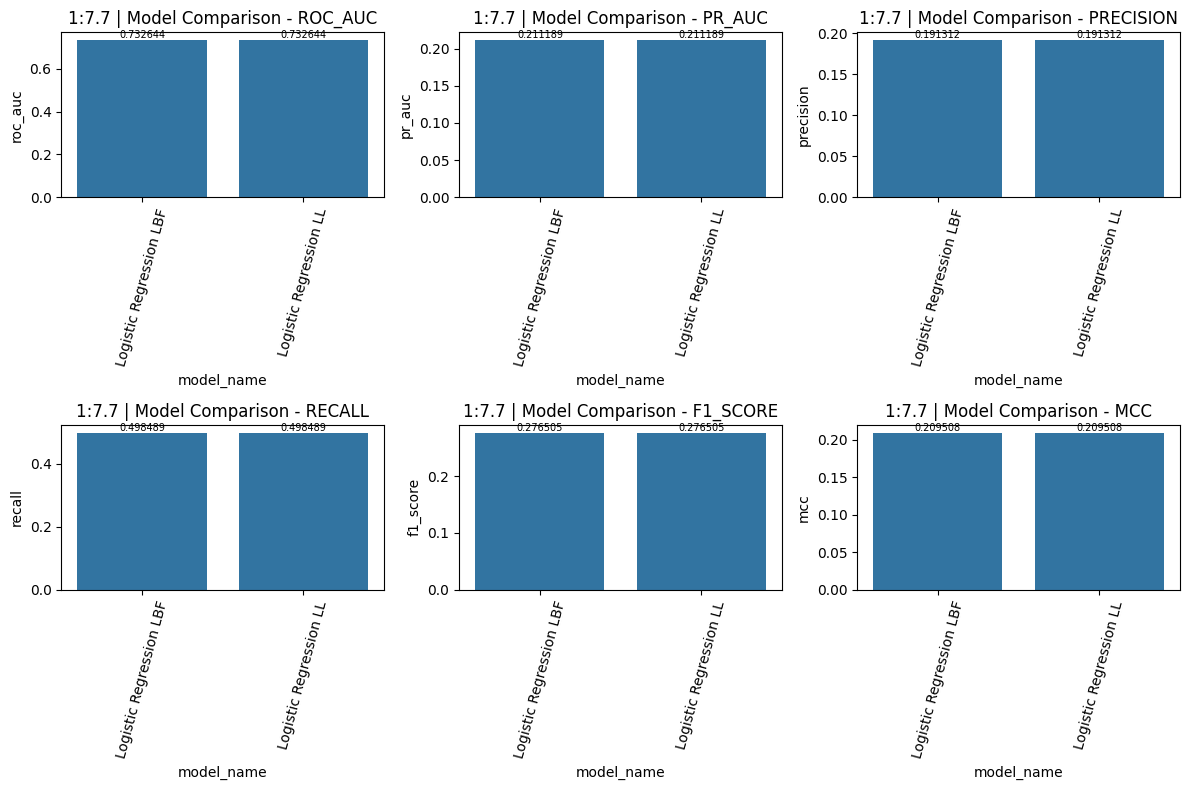

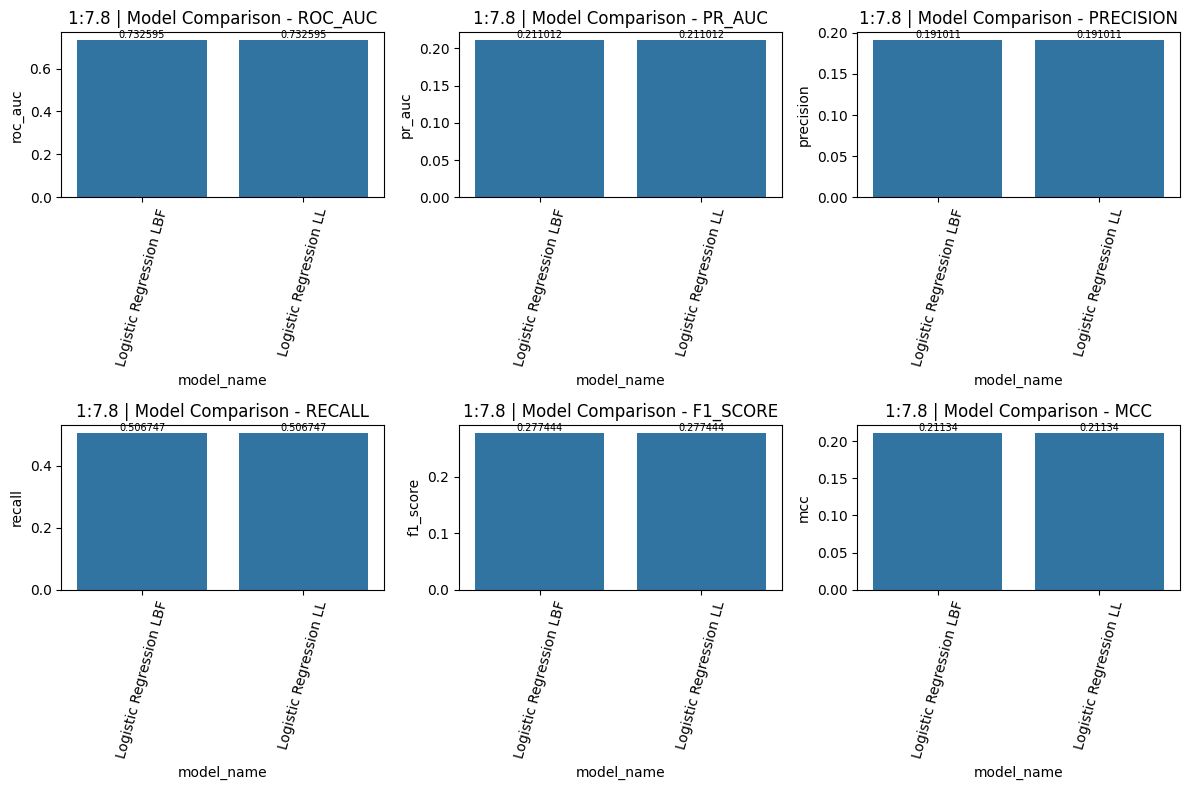

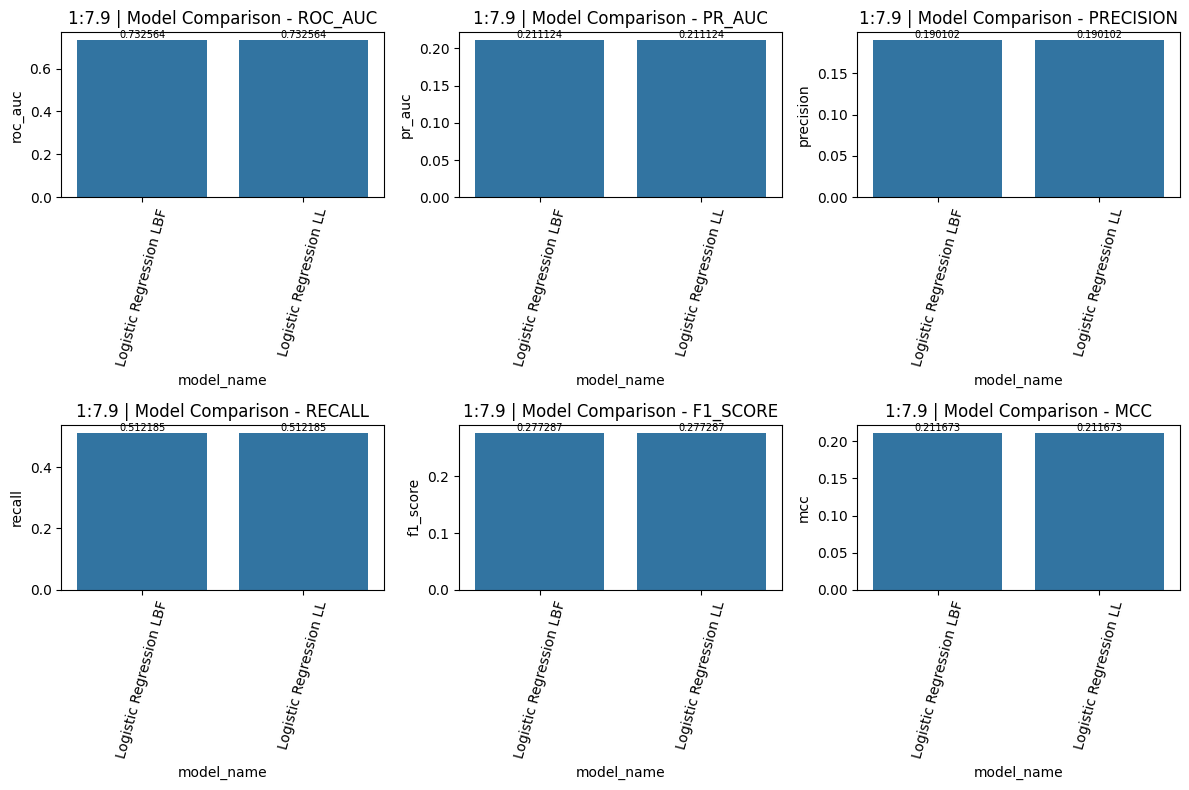

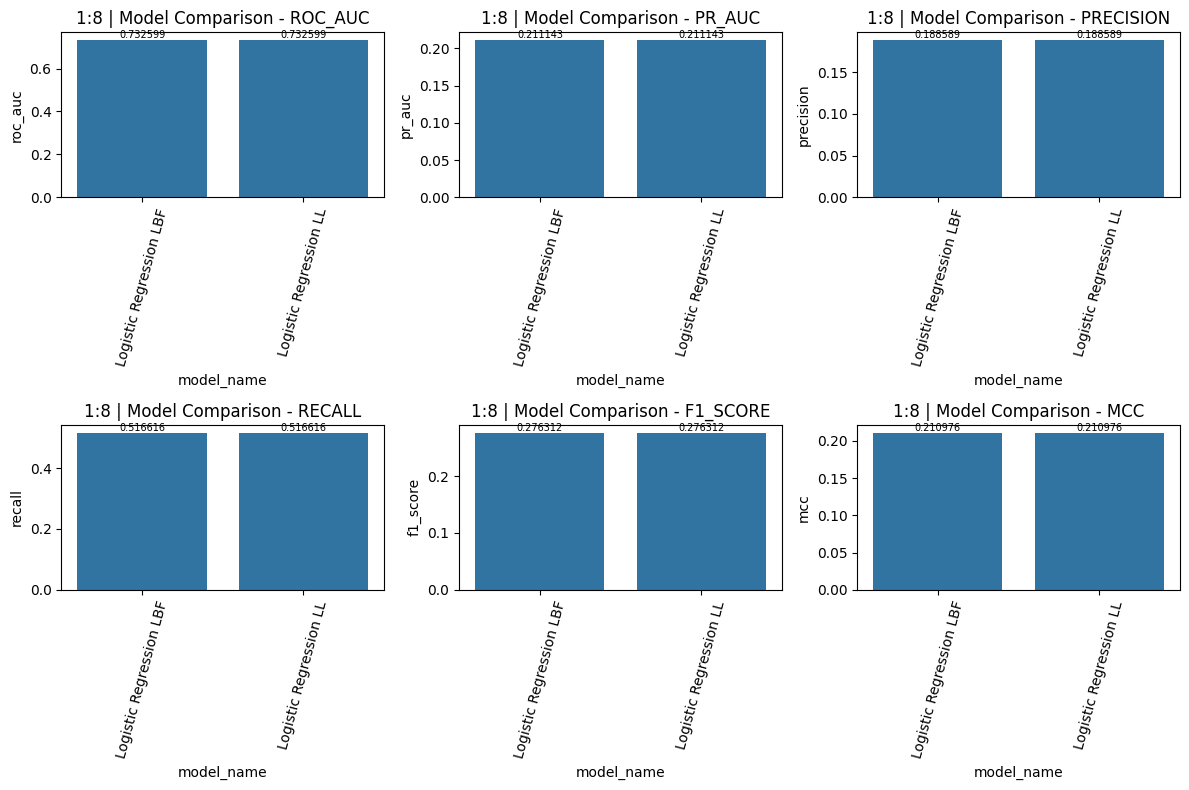

In [ ]:
weights = {'None': {0: 1.0, 1: 1.0},
           '1:7.7': {0: 1.0, 1: 7.7},
           '1:7.8': {0: 1.0, 1: 7.8},
           '1:7.9': {0: 1.0, 1: 7.9},
    '1:8': {0: 1.0, 1: 8},
}


for weight_name, weight_dict in weights.items():
    models = {
        'Logistic Regression LBF': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69, solver='lbfgs'),
        }

    results = []
    for model_name, model in models.items():
        print(f"Evaluating {model_name} with weight:{weight_name}...")

        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)

        # Create classification report
        report = classification_report(y_test, y_pred)

        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_curve, precision_curve)

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
    
        result = {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mcc': mcc,
        'classification_report': report}

        results.append(result)
        print(f"  Accuracy: {result['accuracy']:.4f}")
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall: {result['recall']:.4f}")
        print(f"  F1 Score: {result['f1_score']:.4f}")
        print(f"  ROC AUC: {result['roc_auc']:.4f}")
        print(f"  PR AUC: {result['pr_auc']:.4f}")
        print(f"  MCC: {result['mcc']:.4f}")
        # print(f"  Classification Report:\n{result['classification_report']}\n")

    # Create results summary
    results_df = pd.DataFrame(results)
    results_df = results_df.drop('classification_report', axis=1)
    # results_df.to_csv('ml_results/model_comparison.csv', index=False)

    # Plot model comparison
    plt.figure(figsize=(12, 8))
    metrics = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1_score', 'mcc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        ax = sns.barplot(x='model_name', y=metric, data=results_df)
        ax.bar_label(ax.containers[0],fontsize=7);
        plt.title(f'{weight_name} | Model Comparison - {metric.upper()}')
        plt.xticks(rotation=75)
        plt.tight_layout()

## Different Models

In [719]:
X_train.describe()

,ohe__catimp__OCCUPATION_TYPE_Accountants,ohe__catimp__OCCUPATION_TYPE_Cleaning staff,ohe__catimp__OCCUPATION_TYPE_Cooking staff,ohe__catimp__OCCUPATION_TYPE_Core staff,ohe__catimp__OCCUPATION_TYPE_Drivers,ohe__catimp__OCCUPATION_TYPE_HR staff,ohe__catimp__OCCUPATION_TYPE_High skill tech staff,ohe__catimp__OCCUPATION_TYPE_IT staff,ohe__catimp__OCCUPATION_TYPE_Laborers,ohe__catimp__OCCUPATION_TYPE_Low-skill Laborers,ohe__catimp__OCCUPATION_TYPE_Managers,ohe__catimp__OCCUPATION_TYPE_Medicine staff,ohe__catimp__OCCUPATION_TYPE_Private service staff,ohe__catimp__OCCUPATION_TYPE_Realty agents,ohe__catimp__OCCUPATION_TYPE_Retiree,ohe__catimp__OCCUPATION_TYPE_Sales staff,ohe__catimp__OCCUPATION_TYPE_Secretaries,ohe__catimp__OCCUPATION_TYPE_Security staff,ohe__catimp__OCCUPATION_TYPE_Unemployed,ohe__catimp__OCCUPATION_TYPE_Waiters/barmen staff,ohe__catimp__NAME_TYPE_SUITE_Children,ohe__catimp__NAME_TYPE_SUITE_Family,ohe__catimp__NAME_TYPE_SUITE_Group of people,ohe__catimp__NAME_TYPE_SUITE_Other_A,ohe__catimp__NAME_TYPE_SUITE_Other_B,"ohe__catimp__NAME_TYPE_SUITE_Spouse, partner",ohe__catimp__NAME_TYPE_SUITE_Unaccompanied,ohe__remainder__NAME_INCOME_TYPE_Businessman,ohe__remainder__NAME_INCOME_TYPE_Commercial associate,ohe__remainder__NAME_INCOME_TYPE_Pensioner,ohe__remainder__NAME_INCOME_TYPE_State servant,ohe__remainder__NAME_INCOME_TYPE_Student,ohe__remainder__NAME_INCOME_TYPE_Unemployed,ohe__remainder__NAME_INCOME_TYPE_Working,ohe__remainder__NAME_EDUCATION_TYPE_Academic degree,ohe__remainder__NAME_EDUCATION_TYPE_Higher education,ohe__remainder__NAME_EDUCATION_TYPE_Incomplete higher,ohe__remainder__NAME_EDUCATION_TYPE_Lower secondary,ohe__remainder__NAME_EDUCATION_TYPE_Secondary / secondary special,ohe__remainder__NAME_FAMILY_STATUS_Civil marriage,...,remainder__numimp__AMT_REQ_CREDIT_BUREAU_MON,remainder__numimp__AMT_REQ_CREDIT_BUREAU_QRT,remainder__numimp__AMT_REQ_CREDIT_BUREAU_YEAR,remainder__numimp__AMT_ANNUITY,remainder__numimp__OBS_60_CNT_SOCIAL_CIRCLE,remainder__numimp__DEF_60_CNT_SOCIAL_CIRCLE,remainder__numimp__CNT_FAM_MEMBERS,remainder__numimp__DAYS_LAST_PHONE_CHANGE,remainder__numimp__missingindicator_AMT_REQ_CREDIT_BUREAU_HOUR,remainder__numimp__missingindicator_AMT_REQ_CREDIT_BUREAU_DAY,remainder__numimp__missingindicator_AMT_REQ_CREDIT_BUREAU_WEEK,remainder__numimp__missingindicator_AMT_REQ_CREDIT_BUREAU_MON,remainder__numimp__missingindicator_AMT_REQ_CREDIT_BUREAU_QRT,remainder__numimp__missingindicator_AMT_REQ_CREDIT_BUREAU_YEAR,remainder__numimp__missingindicator_AMT_ANNUITY,remainder__numimp__missingindicator_OBS_60_CNT_SOCIAL_CIRCLE,remainder__numimp__missingindicator_DEF_60_CNT_SOCIAL_CIRCLE,remainder__numimp__missingindicator_CNT_FAM_MEMBERS,remainder__catimp__missingindicator_OCCUPATION_TYPE,remainder__catimp__missingindicator_NAME_TYPE_SUITE,remainder__remainder__NAME_CONTRACT_TYPE,remainder__remainder__CODE_GENDER,remainder__remainder__FLAG_OWN_CAR,remainder__remainder__FLAG_OWN_REALTY,remainder__remainder__CNT_CHILDREN,remainder__remainder__AMT_INCOME_TOTAL,remainder__remainder__AMT_CREDIT,remainder__remainder__REGION_POPULATION_RELATIVE,remainder__remainder__DAYS_BIRTH,remainder__remainder__DAYS_EMPLOYED,remainder__remainder__DAYS_REGISTRATION,remainder__remainder__DAYS_ID_PUBLISH,remainder__remainder__REGION_RATING_CLIENT_W_CITY,remainder__remainder__HOUR_APPR_PROCESS_START,remainder__remainder__REG_REGION_NOT_LIVE_REGION,remainder__remainder__REG_REGION_NOT_WORK_REGION,remainder__remainder__LIVE_REGION_NOT_WORK_REGION,remainder__remainder__REG_CITY_NOT_LIVE_CITY,remainder__remainder__LIVE_CITY_NOT_WORK_CITY,remainder__remainder__FLAG_DOCUMENT_3
count,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000000,246001.000

Evaluating Logistic Regression with weight:None...
[[56536     0]
 [ 4964     1]]
  Precision: 1.0000
  Recall: 0.0002
  F1 Score: 0.0004
  MCC: 0.0136
Evaluating XGBoost Classifier with weight:None...
[[46136 10400]
 [ 3018  1947]]
  Precision: 0.1577
  Recall: 0.3921
  F1 Score: 0.2249
  MCC: 0.1416
Evaluating Gaussian Naive Bayes with weight:None...
[[ 6166 50370]
 [  357  4608]]
  Precision: 0.0838
  Recall: 0.9281
  F1 Score: 0.1537
  MCC: 0.0329
Evaluating Ridge Classifier with weight:None...


/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

[[56536     0]
 [ 4965     0]]
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  MCC: 0.0000
Evaluating SGD Classifier with weight:None...


/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

[[56536     0]
 [ 4965     0]]
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  MCC: 0.0000
Evaluating Logistic Regression with weight:1:8...
[[45631 10905]
 [ 2899  2066]]
  Precision: 0.1593
  Recall: 0.4161
  F1 Score: 0.2304
  MCC: 0.1491
Evaluating XGBoost Classifier with weight:1:8...
[[46136 10400]
 [ 3018  1947]]
  Precision: 0.1577
  Recall: 0.3921
  F1 Score: 0.2249
  MCC: 0.1416
Evaluating Gaussian Naive Bayes with weight:1:8...
[[ 6166 50370]
 [  357  4608]]
  Precision: 0.0838
  Recall: 0.9281
  F1 Score: 0.1537
  MCC: 0.0329
Evaluating Ridge Classifier with weight:1:8...
[[45845 10691]
 [ 2935  2030]]
  Precision: 0.1596
  Recall: 0.4089
  F1 Score: 0.2296
  MCC: 0.1478
Evaluating SGD Classifier with weight:1:8...
[[45134 11402]
 [ 2916  2049]]
  Precision: 0.1523
  Recall: 0.4127
  F1 Score: 0.2225
  MCC: 0.1391
Evaluating Logistic Regression with weight:1:8.5...
[[44105 12431]
 [ 2733  2232]]
  Precision: 0.1522
  Recall: 0.4495
  F1 Score: 0.2274
  MCC: 0.1468

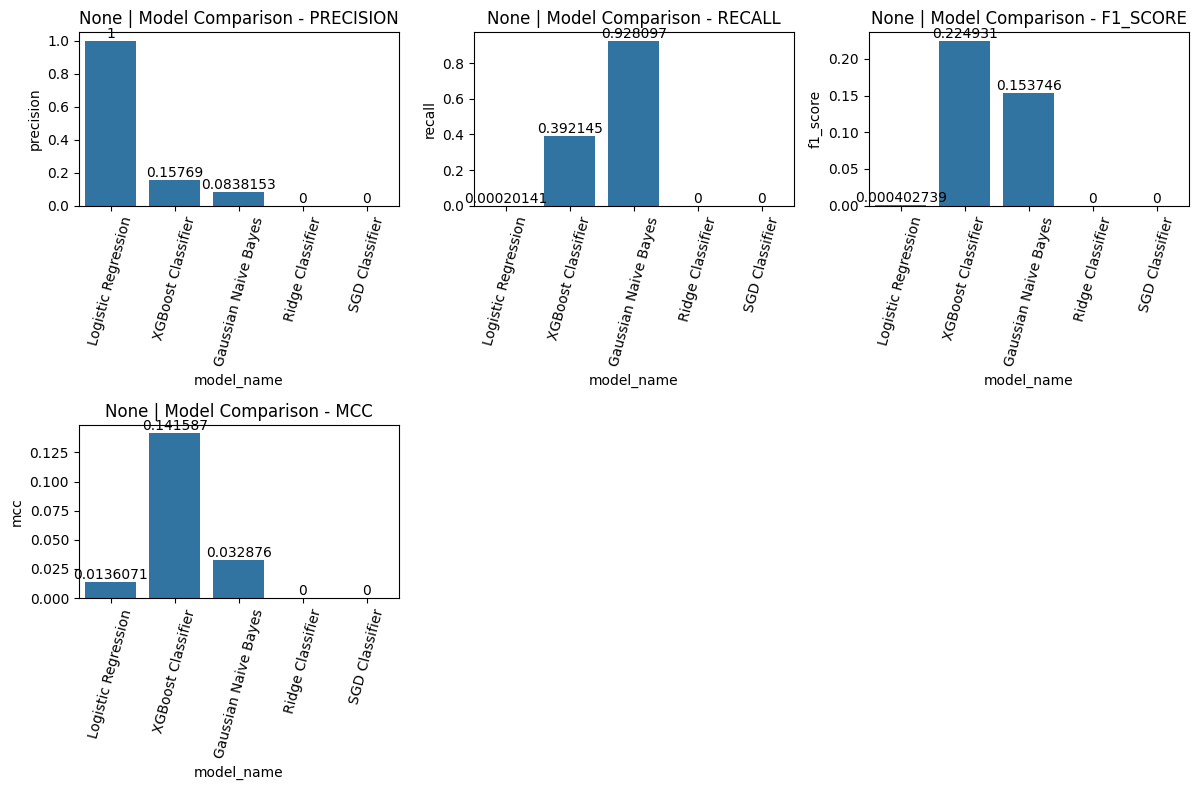

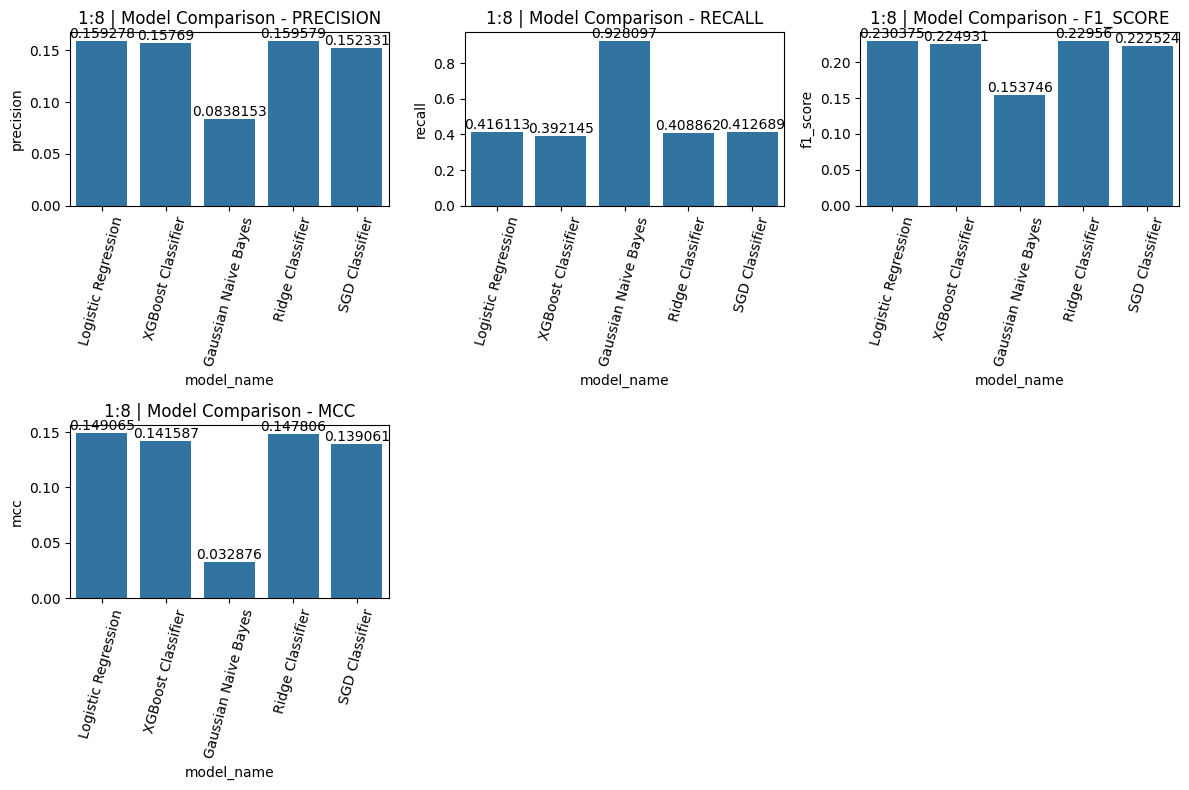

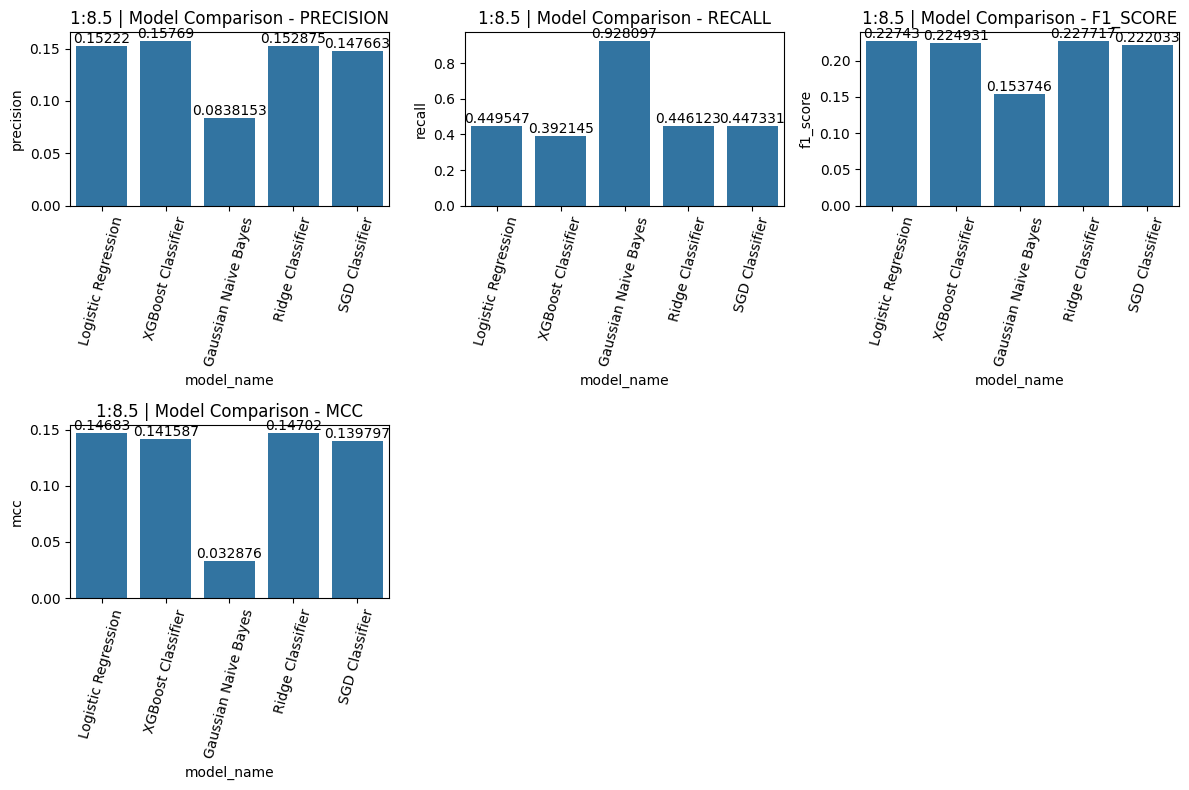

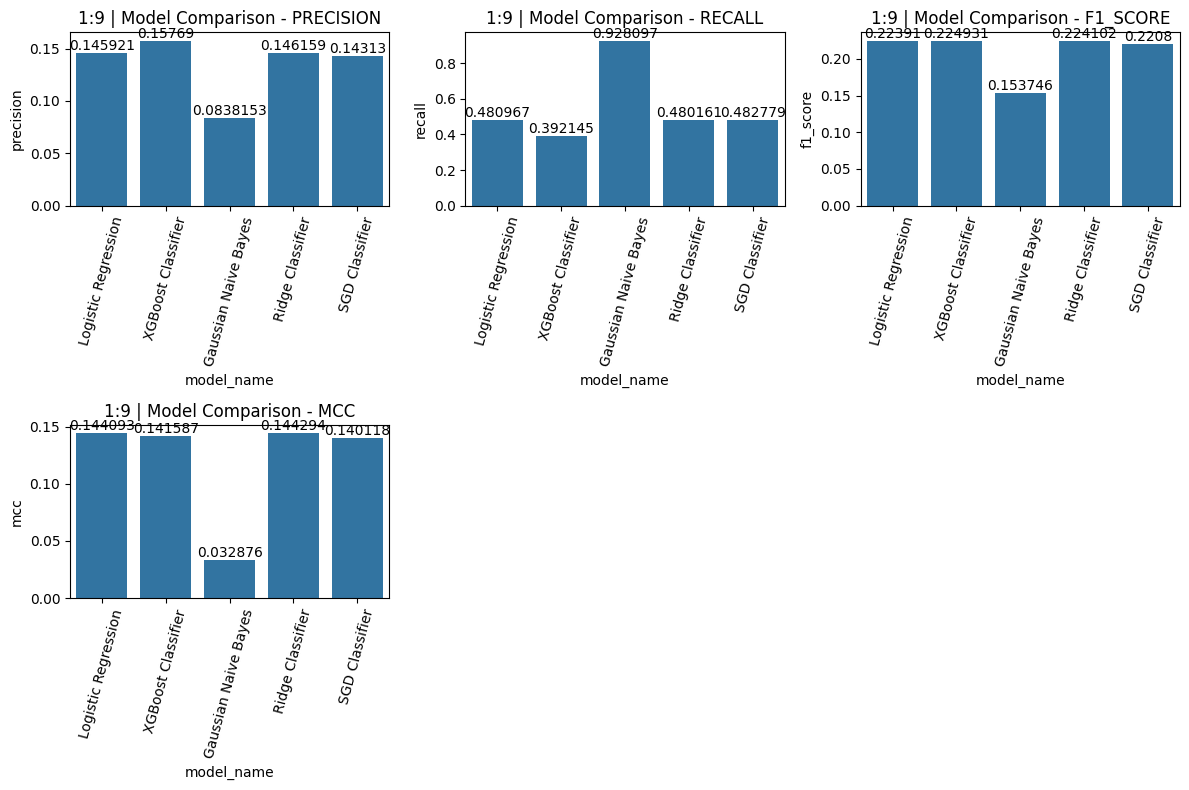

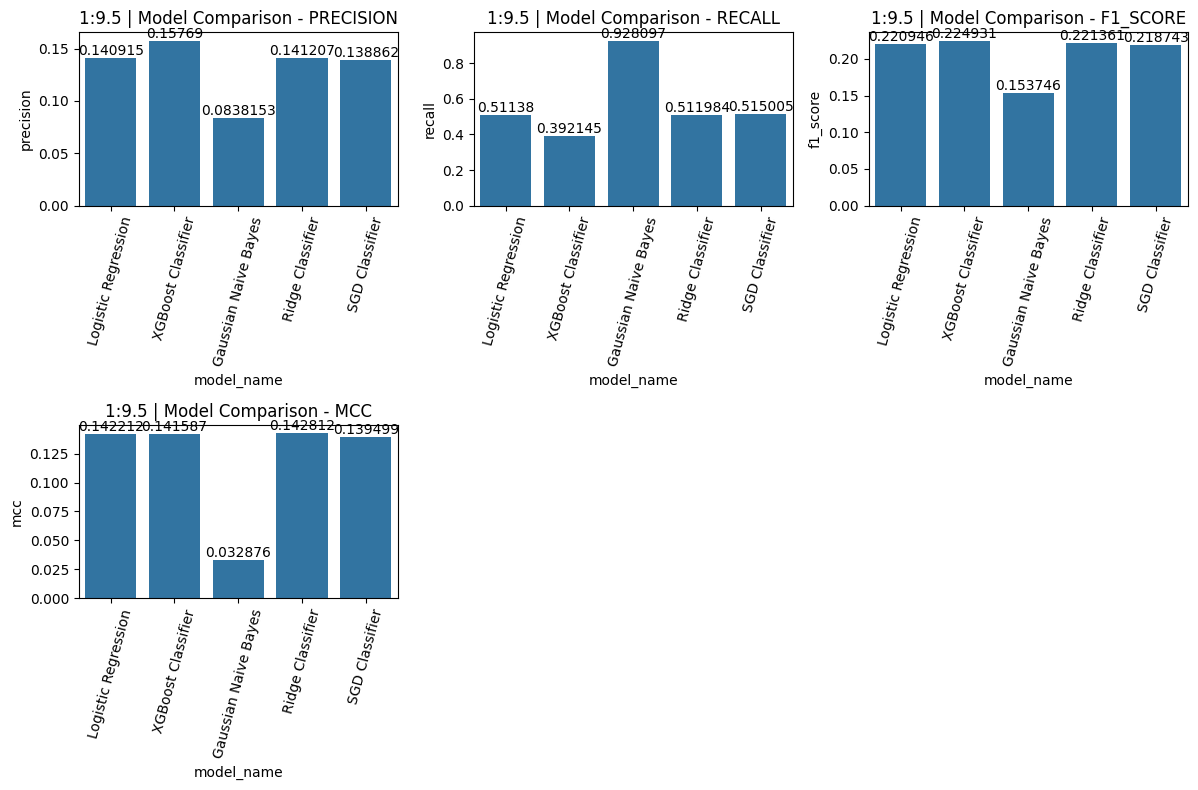

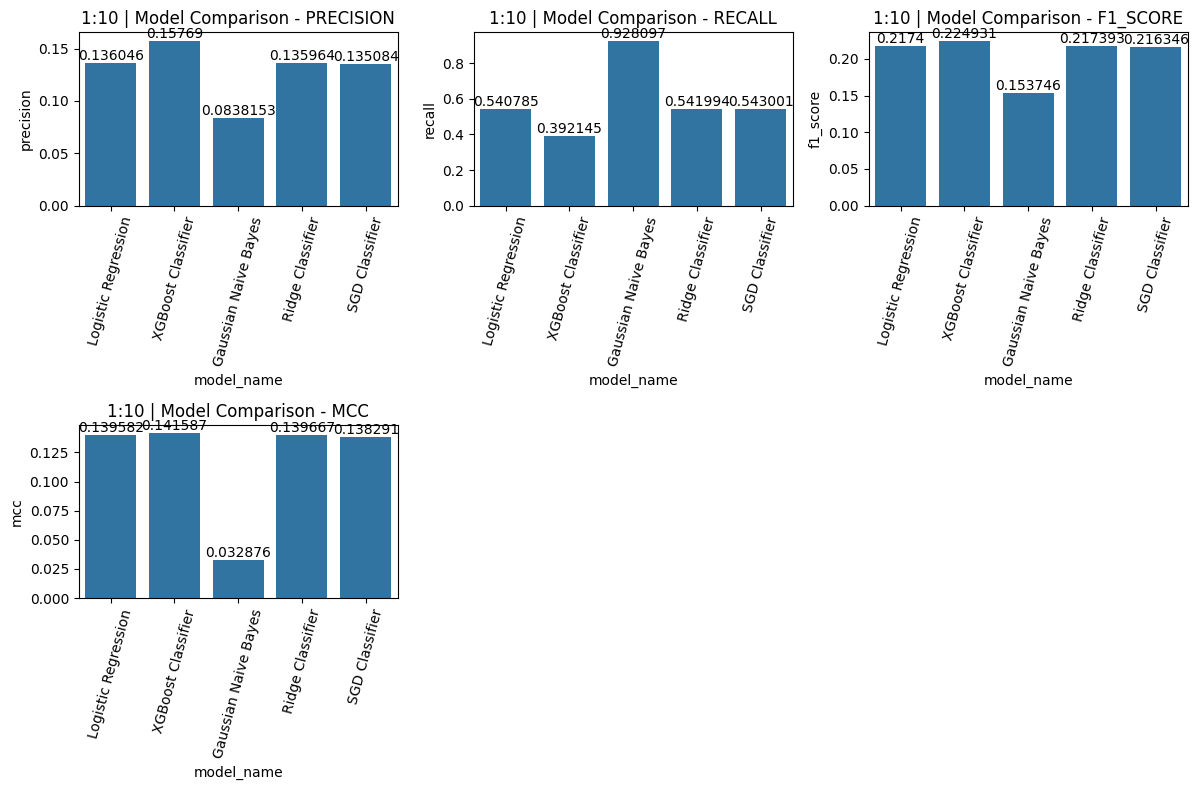

In [724]:
# Evaluating Models with different class weights

# Create a dict of models

from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import RidgeClassifier, SGDClassifier

weights = {'None': {0: 1.0, 1: 1.0},
    '1:8': {0: 1.0, 1: 8},
    '1:8.5': {0: 1.0, 1: 8.5},
    '1:9': {0: 1.0, 1: 9},
    '1:9.5': {0: 1.0, 1: 9.5},
    '1:10': {0: 1.0, 1: 10}}


for weight_name, weight_dict in weights.items():
    models = {
        'Logistic Regression': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69),
        'XGBoost Classifier': XGBClassifier(scale_pos_weight=11, n_estimators=500),
        'Gaussian Naive Bayes': GaussianNB(),
        # 'Complement Naive Bayes': ComplementNB(),
        'Ridge Classifier': RidgeClassifier(random_state=69, class_weight=weight_dict),
        'SGD Classifier': SGDClassifier(loss='log_loss', random_state=69, class_weight=weight_dict)
    }

    results = []
    for model_name, model in models.items():
        print(f"Evaluating {model_name} with weight:{weight_name}...")

        model.fit(X_train, y_train)

        # Predict the labels for the test set
        y_pred = model.predict(X_test)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)

        # Create classification report
        report = classification_report(y_test, y_pred)

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        result = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mcc': mcc,
        'classification_report': report}

        results.append(result)
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall: {result['recall']:.4f}")
        print(f"  F1 Score: {result['f1_score']:.4f}")
        print(f"  MCC: {result['mcc']:.4f}")
        # print(f"  Classification Report:\n{result['classification_report']}\n")

    # Create results summary
    results_df = pd.DataFrame(results)
    results_df = results_df.drop('classification_report', axis=1)
    # results_df.to_csv('ml_results/model_comparison.csv', index=False)

    # Plot model comparison
    plt.figure(figsize=(12, 8))
    metrics = ['precision', 'recall', 'f1_score', 'mcc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        ax = sns.barplot(x='model_name', y=metric, data=results_df)
        ax.bar_label(ax.containers[0],fontsize=10);
        plt.title(f'{weight_name} | Model Comparison - {metric.upper()}')
        plt.xticks(rotation=75)
        plt.tight_layout()

## Smote Resampling

In [ ]:
# Try SMOTE for handling class imbalance
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

print("\nEvaluating models with SMOTE for handling class imbalance...")

model_smote = {
    'Logistic Regression SMOTE': LogisticRegression(max_iter=1000, random_state=69),
    'Decision Tree SMOTE': DecisionTreeClassifier(random_state=69),
    'Random Forest SMOTE': RandomForestClassifier(random_state=69, n_estimators=100),
    'Gradient Boosting SMOTE': GradientBoostingClassifier(random_state=69),
    'XGBoost Classifier SMOTE': XGBClassifier(randomstate=69),
    'XGBoostRF Classifier SMOTE': XGBRFClassifier()
}
smote_results = []

sm = SMOTE(random_state=69)
print('Original dataset shape %s' % Counter(y_train))
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

for model_name, model in model_smote.items():

    print(f"Evaluating {model_name}...")
    result = evaluate_model(model, model_name, X_res, X_test, y_res, y_test)
    smote_results.append(result)
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1 Score: {result['f1_score']:.4f}")
    print(f"  ROC AUC: {result['roc_auc']:.4f}")
    print(f"  PR AUC: {result['pr_auc']:.4f}")
    print(f"  Classification Report:\n{result['classification_report']}\n")

# Create results summary
smote_results_df = pd.DataFrame(smote_results)
smote_results_df = smote_results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison.csv', index=False)

# Plot model comparison
plt.figure(figsize=(12, 8))
metrics = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=smote_results_df)
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()

## Undersampling


Evaluating models with RUS for handling class imbalance...
Evaluating Logistic Regression RUS...
[[34465 22071]
 [ 1833  3132]]
  Precision: 0.1243
  Recall: 0.6308
  F1 Score: 0.2076
  ROC AUC: 0.6666
  PR AUC: 0.1515
  MCC: 0.1332
  Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74     56536
           1       0.12      0.63      0.21      4965

    accuracy                           0.61     61501
   macro avg       0.54      0.62      0.48     61501
weighted avg       0.88      0.61      0.70     61501


Evaluating Decision Tree RUS...
[[31155 25381]
 [ 2263  2702]]
  Precision: 0.0962
  Recall: 0.5442
  F1 Score: 0.1635
  ROC AUC: 0.5476
  PR AUC: 0.3386
  MCC: 0.0521
  Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.55      0.69     56536
           1       0.10      0.54      0.16      4965

    accuracy                           0.55     61501
  

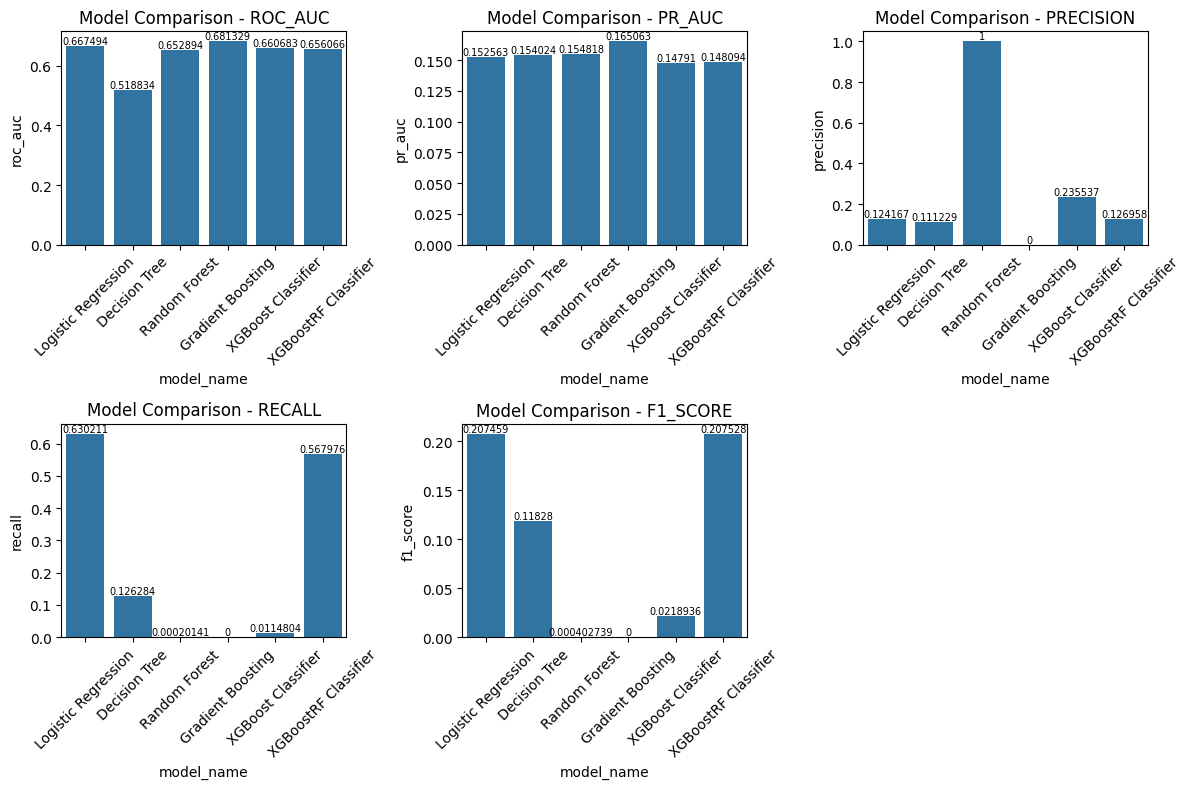

In [ ]:
# Try undersampling for handling class imbalance

from imblearn.under_sampling import RandomUnderSampler

print("\nEvaluating models with RUS for handling class imbalance...")

model_rus = {
    'Logistic Regression RUS': LogisticRegression(max_iter=1000, random_state=69),
    'Decision Tree RUS': DecisionTreeClassifier(random_state=69),
    'Random Forest RUS': RandomForestClassifier(random_state=69, n_estimators=100),
    'Gradient Boosting RUS': GradientBoostingClassifier(random_state=69),
    'XGBoost Classifier RUS': XGBClassifier(),
    'XGBoostRF Classifier RUS': XGBRFClassifier()
}
rus_results = []

ru = RandomUnderSampler(random_state=69)
print('Original dataset shape %s' % Counter(y_train))
X_res, y_res = ru.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))


for model_name, model in model_rus.items():

    print(f"Evaluating {model_name}...")
    result = evaluate_model(model, model_name, X_res, X_test, y_res, y_test)
    rus_results.append(result)
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1 Score: {result['f1_score']:.4f}")
    print(f"  ROC AUC: {result['roc_auc']:.4f}")
    print(f"  PR AUC: {result['pr_auc']:.4f}")
    print(f"  MCC: {result['mcc']:.4f}")
    print(f"  Classification Report:\n{result['classification_report']}\n")

# Create results summary
rus_results_df = pd.DataFrame(rus_results)
rus_results_df = rus_results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison.csv', index=False)

# Plot model comparison
plt.figure(figsize=(12, 8))
metrics = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1_score', 'mcc']
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    ax = sns.barplot(x='model_name', y=metric, data=results_df)
    ax.bar_label(ax.containers[0],fontsize=7);
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()

In [ ]:
# Add resampling results to comparison
results.append(smote_result)
results.append(under_result)
results_df = pd.DataFrame(results)
results_df = results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison_with_resampling.csv', index=False)

# Plot final model comparison
plt.figure(figsize=(14, 10))
metrics = ['roc_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
# plt.savefig('ml_results/final_model_comparison.png')


## Class Weights and Undersampling


Evaluating models with RUS and Class Weights for handling class imbalance...
Original dataset shape Counter({0: 226143, 1: 19858})
Resampled dataset shape Counter({0: 198580, 1: 19858})
Evaluating LR | RUS & CW with weight:None...
[[56448    88]
 [ 4883    82]]
  Precision: 0.4824
  Recall: 0.0165
  F1 Score: 0.0319
  ROC AUC: 0.7328
  PR AUC: 0.2120
  MCC: 0.0776
Evaluating DT | RUS & CW with weight:None...
[[51072  5464]
 [ 4060   905]]
  Precision: 0.1421
  Recall: 0.1823
  F1 Score: 0.1597
  ROC AUC: 0.5428
  PR AUC: 0.1952
  MCC: 0.0766
Evaluating RF | RUS & CW with weight:None...
[[56533     3]
 [ 4952    13]]
  Precision: 0.8125
  Recall: 0.0026
  F1 Score: 0.0052
  ROC AUC: 0.7055
  PR AUC: 0.2030
  MCC: 0.0433
Evaluating GB | RUS & CW with weight:None...
[[56475    61]
 [ 4895    70]]
  Precision: 0.5344
  Recall: 0.0141
  F1 Score: 0.0275
  ROC AUC: 0.7364
  PR AUC: 0.2195
  MCC: 0.0769
Evaluating XBG | RUS & CW with weight:None...
[[56259   277]
 [ 4779   186]]
  Precision:

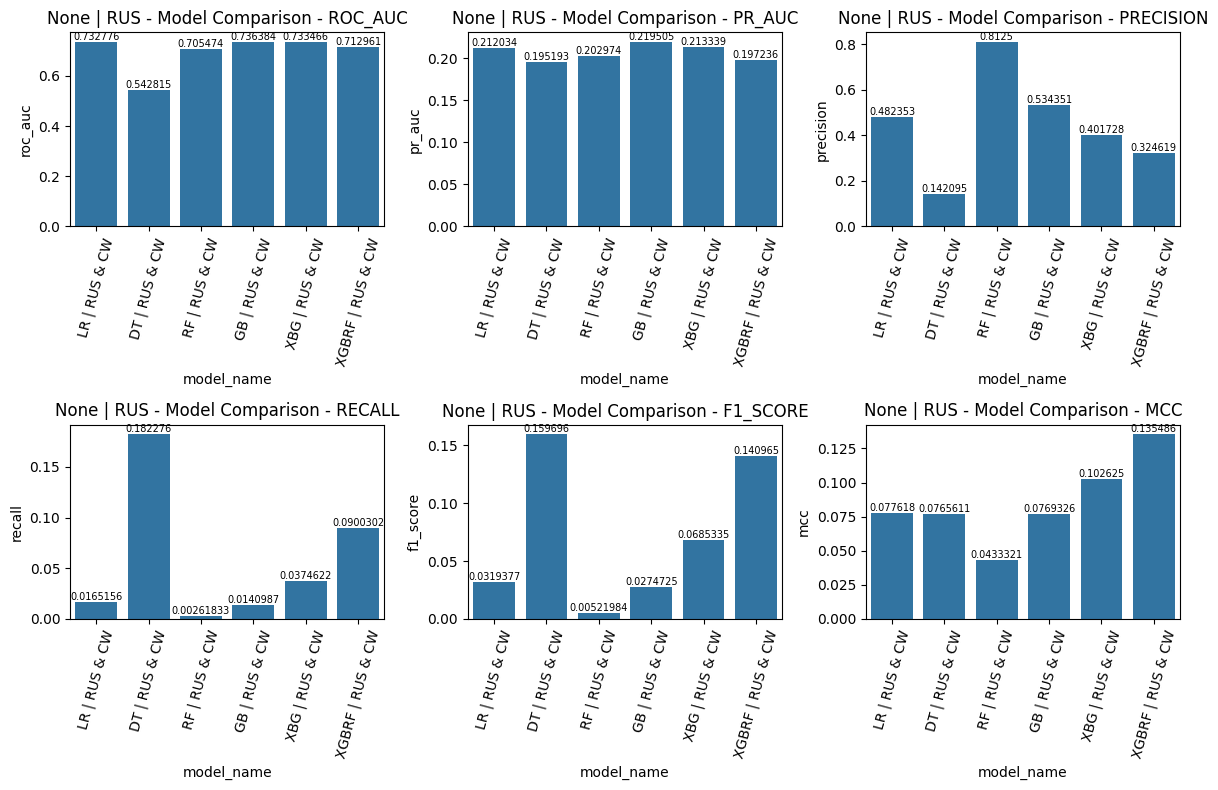

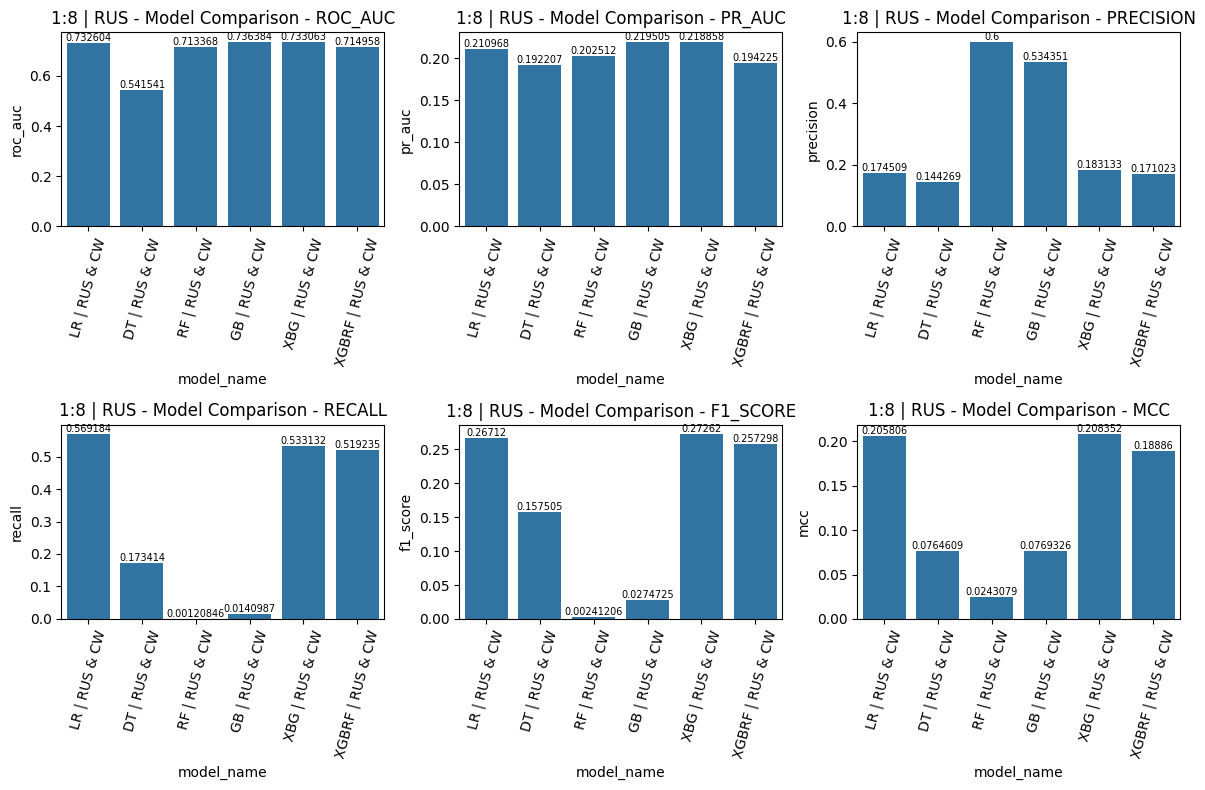

In [67]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

weights = {'None': {0: 1.0, 1: 1.0},
    # '1:1.1': {0: 1.0, 1: 1.1},
    # '1:1.2': {0: 1.0, 1: 1.2},
    # '1:1.3': {0: 1.0, 1: 1.3},
    # '1:2': {0: 1.0, 1: 2},
    '1:8': {0: 1.0, 1: 8}}

print("\nEvaluating models with RUS and Class Weights for handling class imbalance...")


ru = RandomUnderSampler(random_state=69, sampling_strategy=0.1)
print('Original dataset shape %s' % Counter(y_train))
X_rus, y_rus = ru.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_rus))


for weight_name, weight_dict in weights.items():

    model_rus = {
    'LR | RUS & CW': LogisticRegression(class_weight=weight_dict, max_iter=1000, random_state=69),
    'DT | RUS & CW': DecisionTreeClassifier(class_weight=weight_dict,random_state=69),
    'RF | RUS & CW': RandomForestClassifier(class_weight=weight_dict,random_state=69, n_estimators=100),
    'GB | RUS & CW': GradientBoostingClassifier(random_state=69),
    'XBG | RUS & CW': XGBClassifier(scale_pos_weight=weight_dict[1]),
    'XGBRF | RUS & CW': XGBRFClassifier(scale_pos_weight=weight_dict[1])}

    rus_results = []

    for model_name, model in model_rus.items():
        print(f"Evaluating {model_name} with weight:{weight_name}...")
        result = evaluate_model(model, model_name, X_rus, X_test, y_rus, y_test)
        rus_results.append(result)
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall: {result['recall']:.4f}")
        print(f"  F1 Score: {result['f1_score']:.4f}")
        print(f"  ROC AUC: {result['roc_auc']:.4f}")
        print(f"  PR AUC: {result['pr_auc']:.4f}")
        print(f"  MCC: {result['mcc']:.4f}")
        # print(f"  Classification Report:\n{result['classification_report']}\n")

    # Create results summary
    results_df = pd.DataFrame(rus_results)
    results_df = results_df.drop('classification_report', axis=1)
    # results_df.to_csv('ml_results/model_comparison.csv', index=False)

    # Plot model comparison
    plt.figure(figsize=(12, 8))
    metrics = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1_score', 'mcc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        ax = sns.barplot(x='model_name', y=metric, data=results_df)
        ax.bar_label(ax.containers[0],fontsize=7);
        plt.title(f'{weight_name} | RUS - Model Comparison - {metric.upper()}')
        plt.xticks(rotation=75)
        plt.tight_layout()


## AI strategy

In [ ]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Create classification report
    report = classification_report(y_test, y_pred)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    # plt.savefig(f'ml_results/{model_name}_roc_curve.png')
    
    
    # Plot Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure(figsize=(10, 6))
    plt.plot(recall_curve, precision_curve, label=f'PR curve (area = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    # plt.savefig(f'ml_results/{model_name}_pr_curve.png')
    
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    # plt.savefig(f'ml_results/{model_name}_confusion_matrix.png')
    
    
    # Return metrics
    return {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': report
    }

# Define models to evaluate
print("\nDefining models to evaluate...")
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=11.39, random_state=42)  # Using the imbalance ratio
}

# Evaluate each model
print("\nEvaluating models...")
results = []
for name, model in models.items():
    print(f"Evaluating {name}...")
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name.replace(' ', '_'))
    results.append(result)
    print(f"  ROC AUC: {result['roc_auc']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1 Score: {result['f1_score']:.4f}")
    print(f"  Classification Report:\n{result['classification_report']}\n")

# Create results summary
results_df = pd.DataFrame(results)
results_df = results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison.csv', index=False)

# Plot model comparison
plt.figure(figsize=(12, 8))
metrics = ['roc_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
# plt.savefig('ml_results/model_comparison.png')


# Try SMOTE for handling class imbalance
print("\nEvaluating models with SMOTE for handling class imbalance...")
# Define SMOTE pipeline
smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

# Evaluate SMOTE pipeline
smote_result = evaluate_model(smote_pipeline, X_train, X_test, y_train, y_test, 'XGBoost_with_SMOTE')
print(f"  ROC AUC: {smote_result['roc_auc']:.4f}")
print(f"  Precision: {smote_result['precision']:.4f}")
print(f"  Recall: {smote_result['recall']:.4f}")
print(f"  F1 Score: {smote_result['f1_score']:.4f}")
print(f"  Classification Report:\n{smote_result['classification_report']}\n")

# Try undersampling for handling class imbalance
print("\nEvaluating models with undersampling for handling class imbalance...")
# Define undersampling pipeline
under_pipeline = Pipeline([
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

# Evaluate undersampling pipeline
under_result = evaluate_model(under_pipeline, X_train, X_test, y_train, y_test, 'XGBoost_with_Undersampling')
print(f"  ROC AUC: {under_result['roc_auc']:.4f}")
print(f"  Precision: {under_result['precision']:.4f}")
print(f"  Recall: {under_result['recall']:.4f}")
print(f"  F1 Score: {under_result['f1_score']:.4f}")
print(f"  Classification Report:\n{under_result['classification_report']}\n")

# Add resampling results to comparison
results.append(smote_result)
results.append(under_result)
results_df = pd.DataFrame(results)
results_df = results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison_with_resampling.csv', index=False)

# Plot final model comparison
plt.figure(figsize=(14, 10))
metrics = ['roc_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
# plt.savefig('ml_results/final_model_comparison.png')


# Feature importance for the best model (assuming XGBoost performs well)
print("\nCalculating feature importance for XGBoost model...")
xgb_model = XGBClassifier(scale_pos_weight=11.39, random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
# feature_importance.to_csv('ml_results/xgboost_feature_importance.csv', index=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Features by Importance (XGBoost)')
plt.tight_layout()
# plt.savefig('ml_results/xgboost_feature_importance.png')


print("\nMachine learning evaluation completed. Results saved to ml_results directory.")

# Summary of recommended approaches
print("\nRecommended Machine Learning Approaches for Loan Default Prediction:")
print("1. Gradient Boosting and XGBoost models typically perform well for this type of problem")
print("2. Class imbalance handling techniques like SMOTE or class weights are essential")
print("3. Feature selection based on importance can improve model performance")
print("4. Evaluation should focus on metrics like ROC AUC, Precision, Recall, and F1 Score")
print("5. Threshold tuning can help balance precision and recall based on business requirements")


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [ ]:
model.fit(X_train, y_train)

## Code that we didn't use but I want to keep

In [ ]:
# # Encode categorical variables
# print('Encoding categorical variables...')
# # Apply label encoding to categorical columns
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     df_cleaned[col] = le.fit_transform(df_cleaned[col])
#     label_encoders[col] = le
    
# print(f'Encoded {len(categorical_cols)} categorical columns')


# # Impute missing values for categorical columns with most frequent value
# cat_imp = ColumnTransformer(transformers=[('catimp', SimpleImputer(strategy='mode', add_indicator=True), categorical_cols)], 
#                        remainder="passthrough").set_output(transform='pandas')
# # num_imputer = SimpleImputer(strategy='mean', add_indicator=True)
# df_cat_imputed = num_imp.fit_transform(df_num_imputed)

# Fuck all this trash
# # we need to impute first before one-hot encoding and feature scaling
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import SimpleImputer, IterativeImputer
# from sklearn.linear_model import BayesianRidge
# from sklearn.neighbors import KNeighborsRegressor

# # let's use Bayesian Ridge(default) to impute missing values for Numerical col, then we can go back and compare strategies

# # need to create a separate dataframe for the columns we want to impute
# num_missing_col = ['AMT_REQ_CREDIT_BUREAU_HOUR',
#  'AMT_REQ_CREDIT_BUREAU_DAY',
#  'AMT_REQ_CREDIT_BUREAU_WEEK',
#  'AMT_REQ_CREDIT_BUREAU_MON',
#  'AMT_REQ_CREDIT_BUREAU_QRT',
#  'AMT_REQ_CREDIT_BUREAU_YEAR']

# num_missing_df = X_train[num_missing_col]

# num_imputer = IterativeImputer(
#     estimator=BayesianRidge(),
#     # add_indicator=True,
#     random_state=42,
#     n_nearest_features=3,
#     sample_posterior=True
# )

# num_imputed_array = num_imputer.fit_transform(num_missing_df)
# num_imputed_df = pd.DataFrame(num_imputed_array, columns=num_missing_df.columns)